### Disentangling candidate core virulence genes of _Ralstonia solanacearum_ across different hosts

Cristian David Grisales Vargas
cristian.grisales@udea.edu.co

### 1. RNA-seq Quality and Alignment

### 1.1. Required tools:

-Trimmomatic
-Fastqc
-Hisat2
-Samtools
-FeatureCounts

### 1.2. Trimming and Quality control commands:

**Trimming**\
trimmomatic SE -threads $threads -phred33 file1.fastq.gz file1.fq 
ILLUMINACLIP:TruSeq3-SE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36 AVGQUAL:30

**Read Quality**\
fastqc file1.fq -o fastqc_file1

### S1. Per base sequence quality

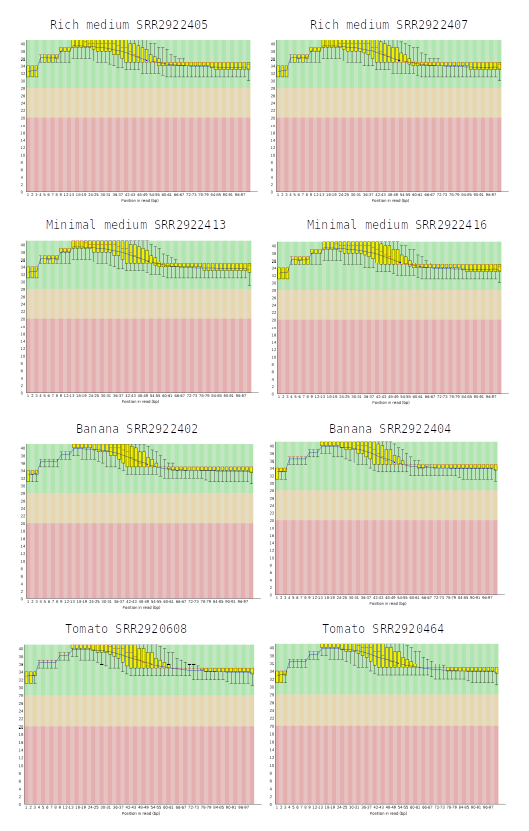

In [17]:
display_png(file="fastqc.png")  

### 1.3. Alignment commands:

**Create index**\
hisat2-build UW163_genome.fasta index_genome_UW163

**Alingment**\
hisat2 -q -x index_genome_UW163 --threads 16 -U file1.fq -S fil1.sam

**Sorting**\
samtools sort file1.bam -o file1.bam  -O BAM

**Create index**\
samtools index file1.bam

**Create index**\
samtools sort  file1.bam -o file1_sort.bam  -O BAM

**Create index**\
samtools index file1_sort.bam

### S2. Annotation quality

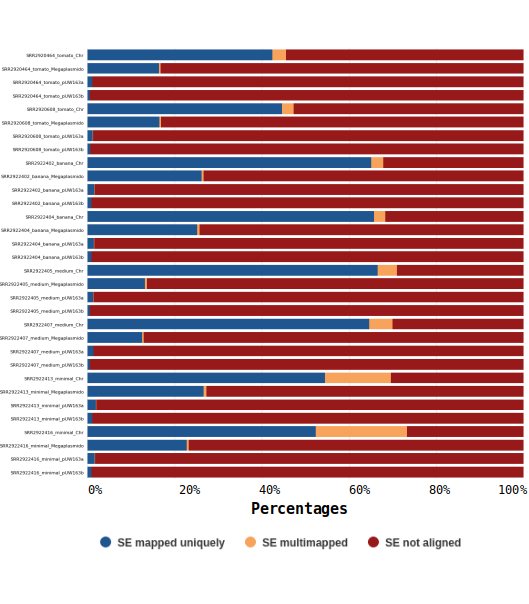

In [51]:
display_png(file="Assembly.png")

### 1.3. Count Matrix command:

**Count Matrix**\
featureCounts -O -T 16 -t CDS -g locus_tag -a UW163.gtf -o matrix_UW163.txt file1_sort.bam

### 2. Exploring Data with R

#### 2.1.Library request 

In [ ]:
library(RColorBrewer)
library(ggplot2)
library(limma)
library(DESeq)
library(edgeR)
library(gplots)
library(reshape2)
library(plyr)
library(DEFormats)
library(gridExtra)
library(grid)
library(cluster)
library(devtools)
library(tikzDevice)
library(viridis)
library(pheatmap)
library(IRdisplay)

#### 2.1. Exploring dataset

In [1]:
#------------------------------------------------------------#
#---------Count Matrix of genes obtain with FeatureCounts----#
#------------------------------------------------------------#
Ralstonia_L <- read.table('Main.txt',sep='\t',header=T,row.names=1)
Ralstonia <- Ralstonia_L[,-1] # Remove Length column
head(as.matrix(Ralstonia))

,Control.R1,Control.R2,Tomato.R1,Tomato.R2,Minimal.R1,Minimal.R2,Banana.R1,Banana.R2
UW163_00020,0,2,0,1,1,1,0,0
UW163_00025,0,0,2,0,0,0,2,2
UW163_00030,0,1,0,0,0,0,0,0
UW163_00040,0,0,0,0,0,0,0,0
UW163_00045,0,0,1,0,0,0,0,0
UW163_00050,1,0,0,0,0,0,0,0


In [2]:
#------------------------------------------------------------#
#-----------------------Target File--------------------------#
#------------------------------------------------------------#
#It is required in order to normalize by size.
target    <- read.table ("Targets_R.txt", header=T)
condition <- target$Condition
head(target)

,ID,Condition
,<fct>,<fct>
1,Control.R1,Control
2,Control.R2,Control
3,Tomato.R1,Tomato
4,Tomato.R2,Tomato
5,Minimal.R1,Minimal
6,Minimal.R2,Minimal


In [3]:
#------------------------------------------------------------#
#-----------filtering rows with very small counts------------#
#------------------------------------------------------------#
Ralstonia[, "max"]<- apply(Ralstonia[ , ], 1, max)       # Make a new column with row maximum values
Filtered_Ral<-Ralstonia[Ralstonia[,ncol(Ralstonia)]>32,] # Remove rows with maximum values below threshold (<32)
Filtered_Ral<- Filtered_Ral[,-ncol(Filtered_Ral)]        # Remove maximum values column
head(as.matrix(Filtered_Ral))

,Control.R1,Control.R2,Tomato.R1,Tomato.R2,Minimal.R1,Minimal.R2,Banana.R1,Banana.R2
UW163_00100,18,21,19,22,46,26,42,42
UW163_00105,34,43,51,61,69,50,136,136
UW163_00110,57,88,193,207,136,104,188,188
UW163_00115,26,42,68,77,48,40,43,43
UW163_00120,51,56,111,120,146,104,93,93
UW163_00125,62,74,288,349,391,266,191,191


In [12]:
#------------------------------------------------------------#
#------------------Normalize once for all--------------------#
#------------------------------------------------------------#
cds<-newCountDataSet(Filtered_Ral, condition) 
cds<-estimateSizeFactors(cds) 
norm<-(counts(cds, normalized=TRUE)) # Object where to put normalized counts
head(norm)

,Control.R1,Control.R2,Tomato.R1,Tomato.R2,Minimal.R1,Minimal.R2,Banana.R1,Banana.R2
UW163_00100,17.99845,19.40197,24.24226,25.94283,43.13959,37.29713,29.59209,30.76568
UW163_00105,33.99708,39.72784,65.07133,71.93238,64.70938,71.72525,95.82201,99.62221
UW163_00110,56.99510,81.30349,246.25031,244.09842,127.54313,149.18851,132.45984,137.71306
UW163_00115,25.99777,38.80394,86.76177,90.79990,45.01522,57.38020,30.29667,31.49820
UW163_00120,50.99562,51.73858,141.62583,141.50633,136.92131,149.18851,65.52535,68.12401
UW163_00125,61.99468,68.36884,367.46161,411.54758,366.68651,381.57831,134.57356,139.91061


### 3. Quality and Filtering

### S3. Boxplot

In [ ]:
#------------------------------------------------------------#
#------------------------Data Boxplot------------------------#
#------------------------------------------------------------#
Ralstonia_L <- read.table('Main.txt',sep='\t',header=T,row.names=1)
Ralstonia <- Ralstonia_L[,-1] # Remove Length column
options(warn = -1)
suppressWarnings(melted_Rals <- melt(Ralstonia))
melted_Rals$title <- "Boxplot Data"

#------------------------------------------------------------#
#------------------------Normalize Data----------------------#
#------------------------------------------------------------#
options(warn = -1)
suppressWarnings(melted_Rals2 <- melt(norm))
melted_Rals2$title <- "Boxplot Normalize Data"

In [20]:
#------------------------------------------------------------#
#-------------------------Theme ggplot-----------------------#
#------------------------------------------------------------#
My_Theme = theme(
  axis.title.x = element_text(size=20, vjust=0.001,face="bold"),
  axis.text.x = element_text(size = 17,angle = 30, color = "black", vjust=0.5),
  axis.title.y =element_text(size=20, vjust=1),
  axis.text.y = element_text(size = 17,color = "black" ),
  legend.title = element_blank(),
  legend.position = "none",
  strip.text.x= element_text(size = 22),
  panel.background = element_rect(fill = "grey95"))

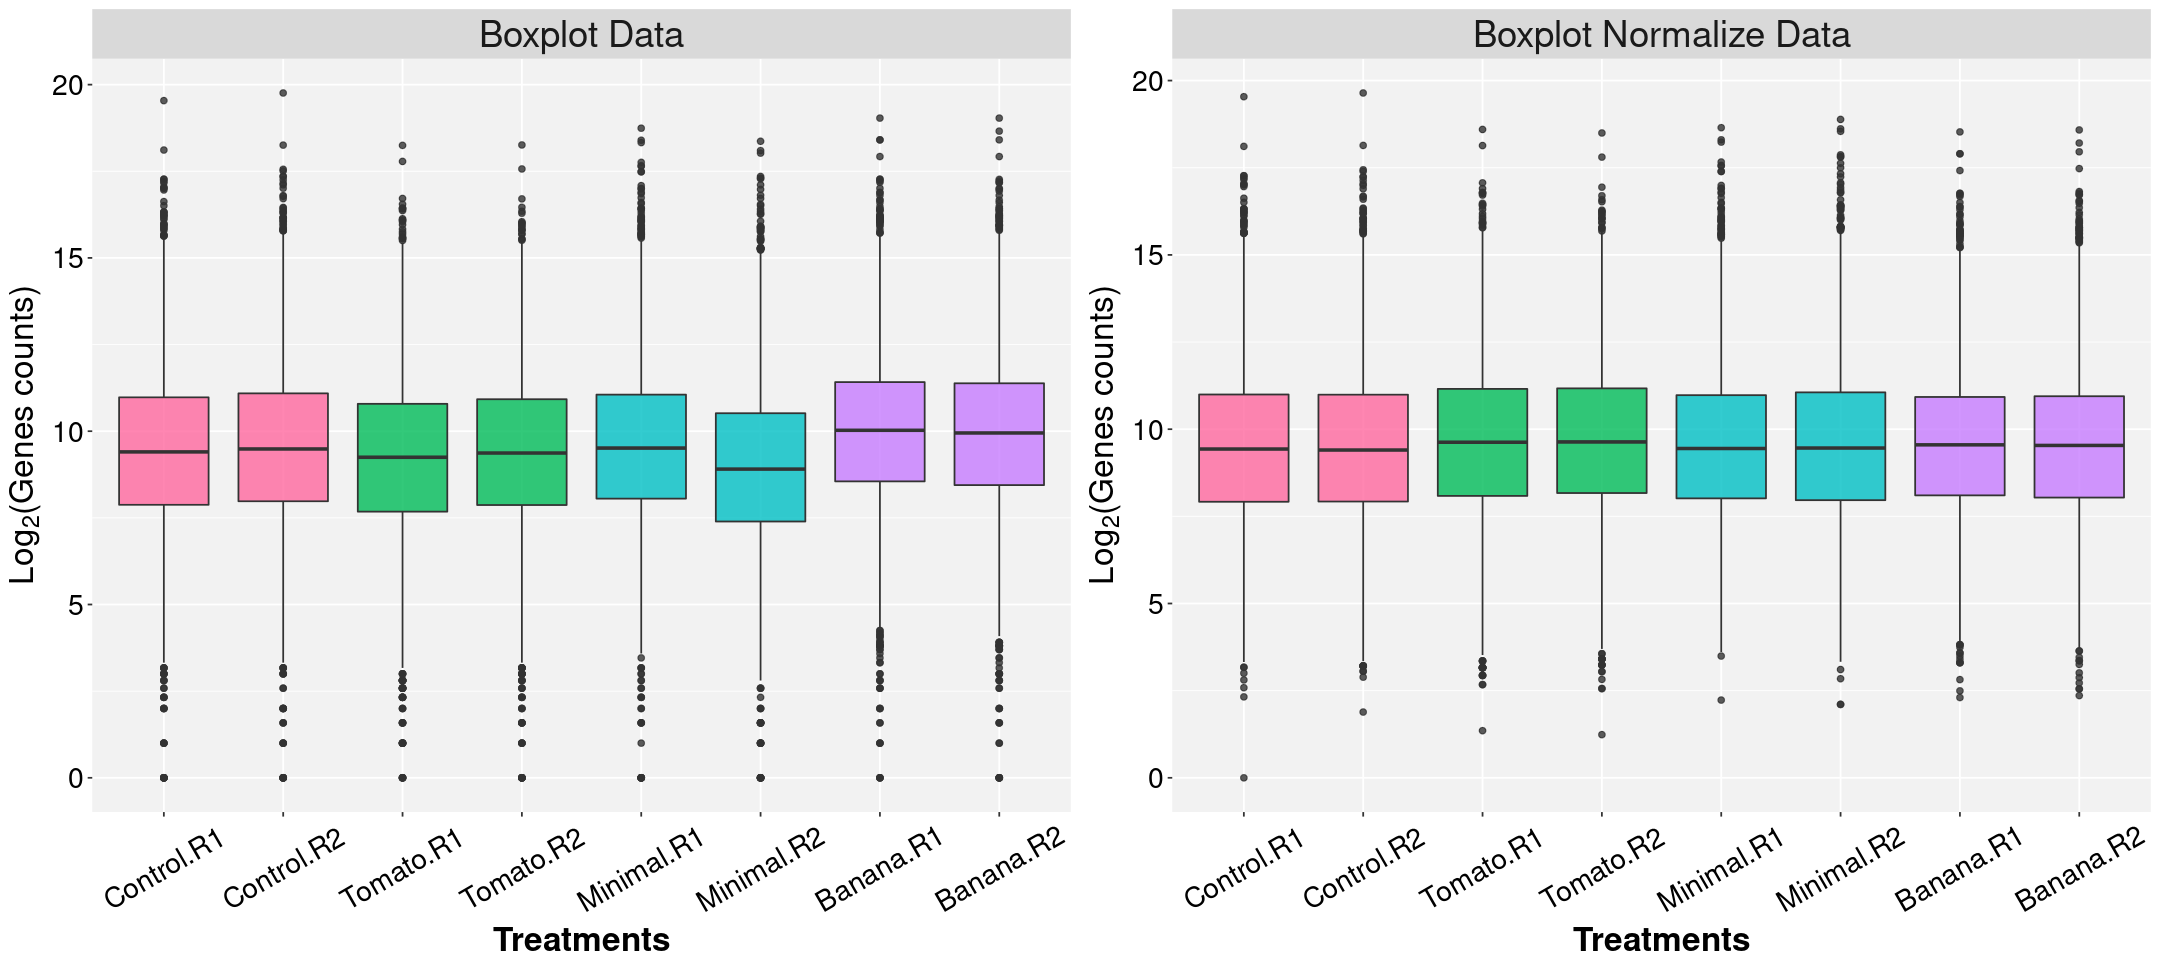

In [21]:
#------------------------------------------------------------#
#------------------------Boxplot-----------------------------#
#------------------------------------------------------------#
boxplot_data <- ggplot(melted_Rals, aes(variable, log2(value), fill=variable)) + geom_boxplot(alpha=0.8) +
                scale_fill_manual(values=c("#FF689F", "#FF689F","#00BC59","#00BC59",
                                           "#00BFC4","#00BFC4","#C77CFF","#C77CFF" )) +
                 My_Theme + ylab(expression(paste(Log[2],"(Genes counts)")))+ xlab("Treatments")+
                 facet_grid(. ~ title)

#------------------------------------------------------------#
#-------------------Boxplot Normalize Data-------------------#
#------------------------------------------------------------#
boxplot_data2 <- ggplot(melted_Rals2, aes(Var2, log2(value), fill=Var2)) + geom_boxplot(alpha=0.8) +
                 scale_fill_manual(values=c("#FF689F", "#FF689F","#00BC59","#00BC59", 
                                            "#00BFC4","#00BFC4","#C77CFF","#C77CFF" )) +
                 My_Theme + ylab(expression(paste(Log[2],"(Genes counts)")))+ xlab("Treatments") + 
                 facet_grid(. ~ title)

#------------------------------------------------------------#
#-------------Display together Boxplot-------------#
#------------------------------------------------------------#

options(repr.plot.width = 18) 
options(repr.plot.height = 8) 
Fig_dispersion <- grid.arrange(boxplot_data, boxplot_data2, nrow = 1, ncol=2)

### S4. Barplot

In [16]:
#------------------------------------------------------------#
#------------------------Data Barplot------------------------#
#------------------------------------------------------------#
tratamientos <- c(names(Ralstonia))
million  <- c(colSums(Ralstonia))
df <- data.frame(tratamientos,million)
head(df)

,tratamientos,million
,<fct>,<dbl>
Control.R1,Control.R1,14930805
Control.R2,Control.R2,16305829
Tomato.R1,Tomato.R1,11390995
Tomato.R2,Tomato.R2,11781221
Minimal.R1,Minimal.R1,15248485
Minimal.R2,Minimal.R2,11052417


In [17]:
#------------------------------------------------------------#
#-------------------------Theme ggplot-----------------------#
#------------------------------------------------------------#
My_Theme = theme(
  axis.title.x = element_text(size=20, vjust=0.5, face = "bold"),
  axis.text.x = element_text(size = 17,angle = 30, color = "black", vjust=0.5),
  axis.title.y =element_text(size=20, vjust=1),
  axis.text.y = element_text(size = 17,color = "black",face = "bold"),
  panel.background = element_rect(fill = "white", colour = "grey50"),
  legend.title = element_blank(),
  legend.position = "none")

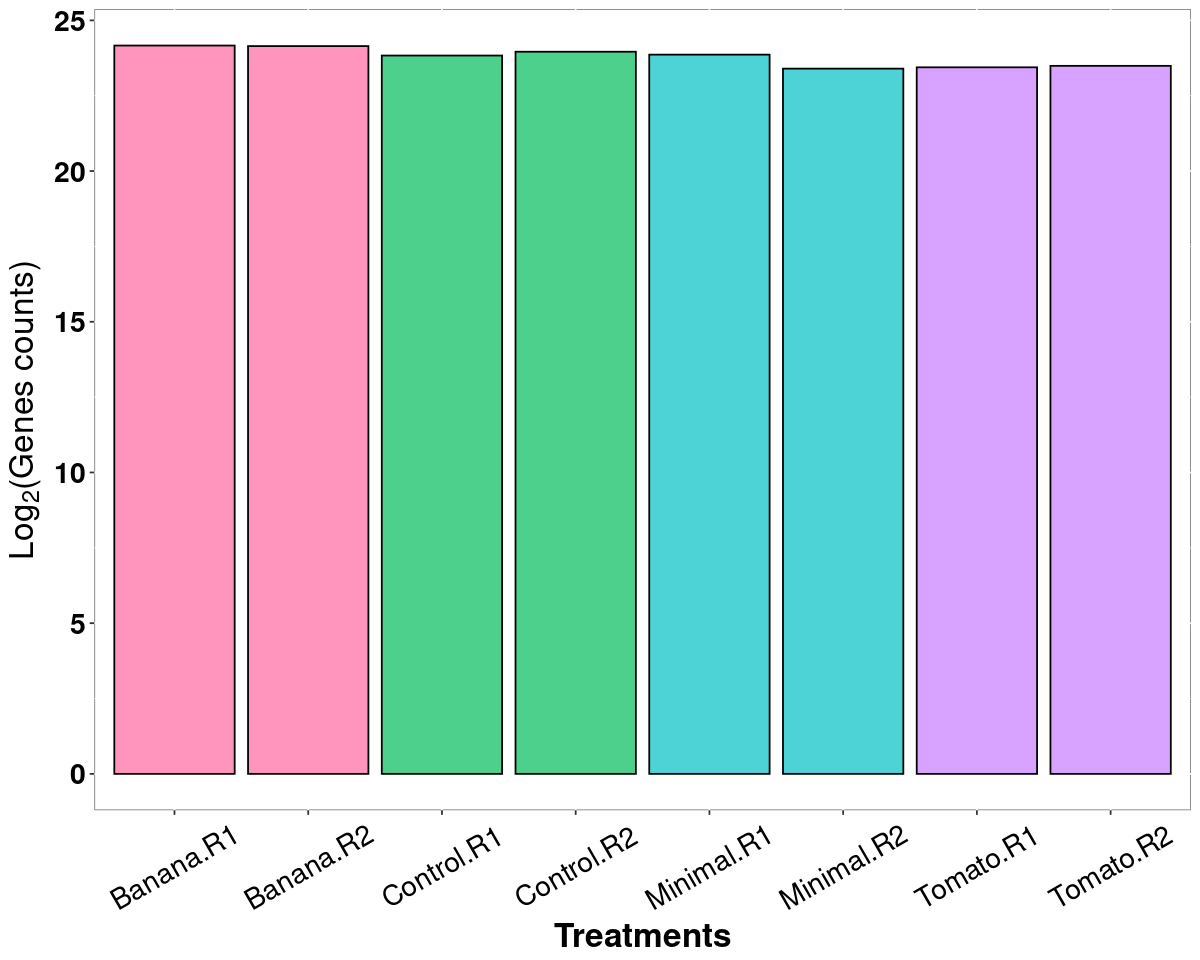

In [18]:
#------------------------------------------------------------#
#--------------------------Barplot---------------------------#
#------------------------------------------------------------#
options(repr.plot.width = 10)
options(repr.plot.height = 8)
barp <- ggplot(df, aes(x=tratamientos, y=log2(million), fill=tratamientos)) +
        geom_bar(stat="identity", color="black", alpha=0.7) + My_Theme +
        scale_fill_manual(values=c("#FF689F", "#FF689F","#00BC59",
                                   "#00BC59", "#00BFC4","#00BFC4","#C77CFF","#C77CFF"))+
        ylab(expression(paste(Log[2],"(Genes counts)")))+ xlab("Treatments")
barp

### S5. Linear Regression 

In [13]:
#------------------------------------------------------------#
#--------------------Theme of the ggplot --------------------#
#------------------------------------------------------------#
My_Theme = theme(
  axis.title.x = element_text(size=18, vjust=1,face="bold"),
  axis.text.x = element_text(size = 15),
  axis.title.y =element_text(size=18, vjust=1,face="bold"),
  axis.text.y = element_text(size = 15))
options(warn=-1)

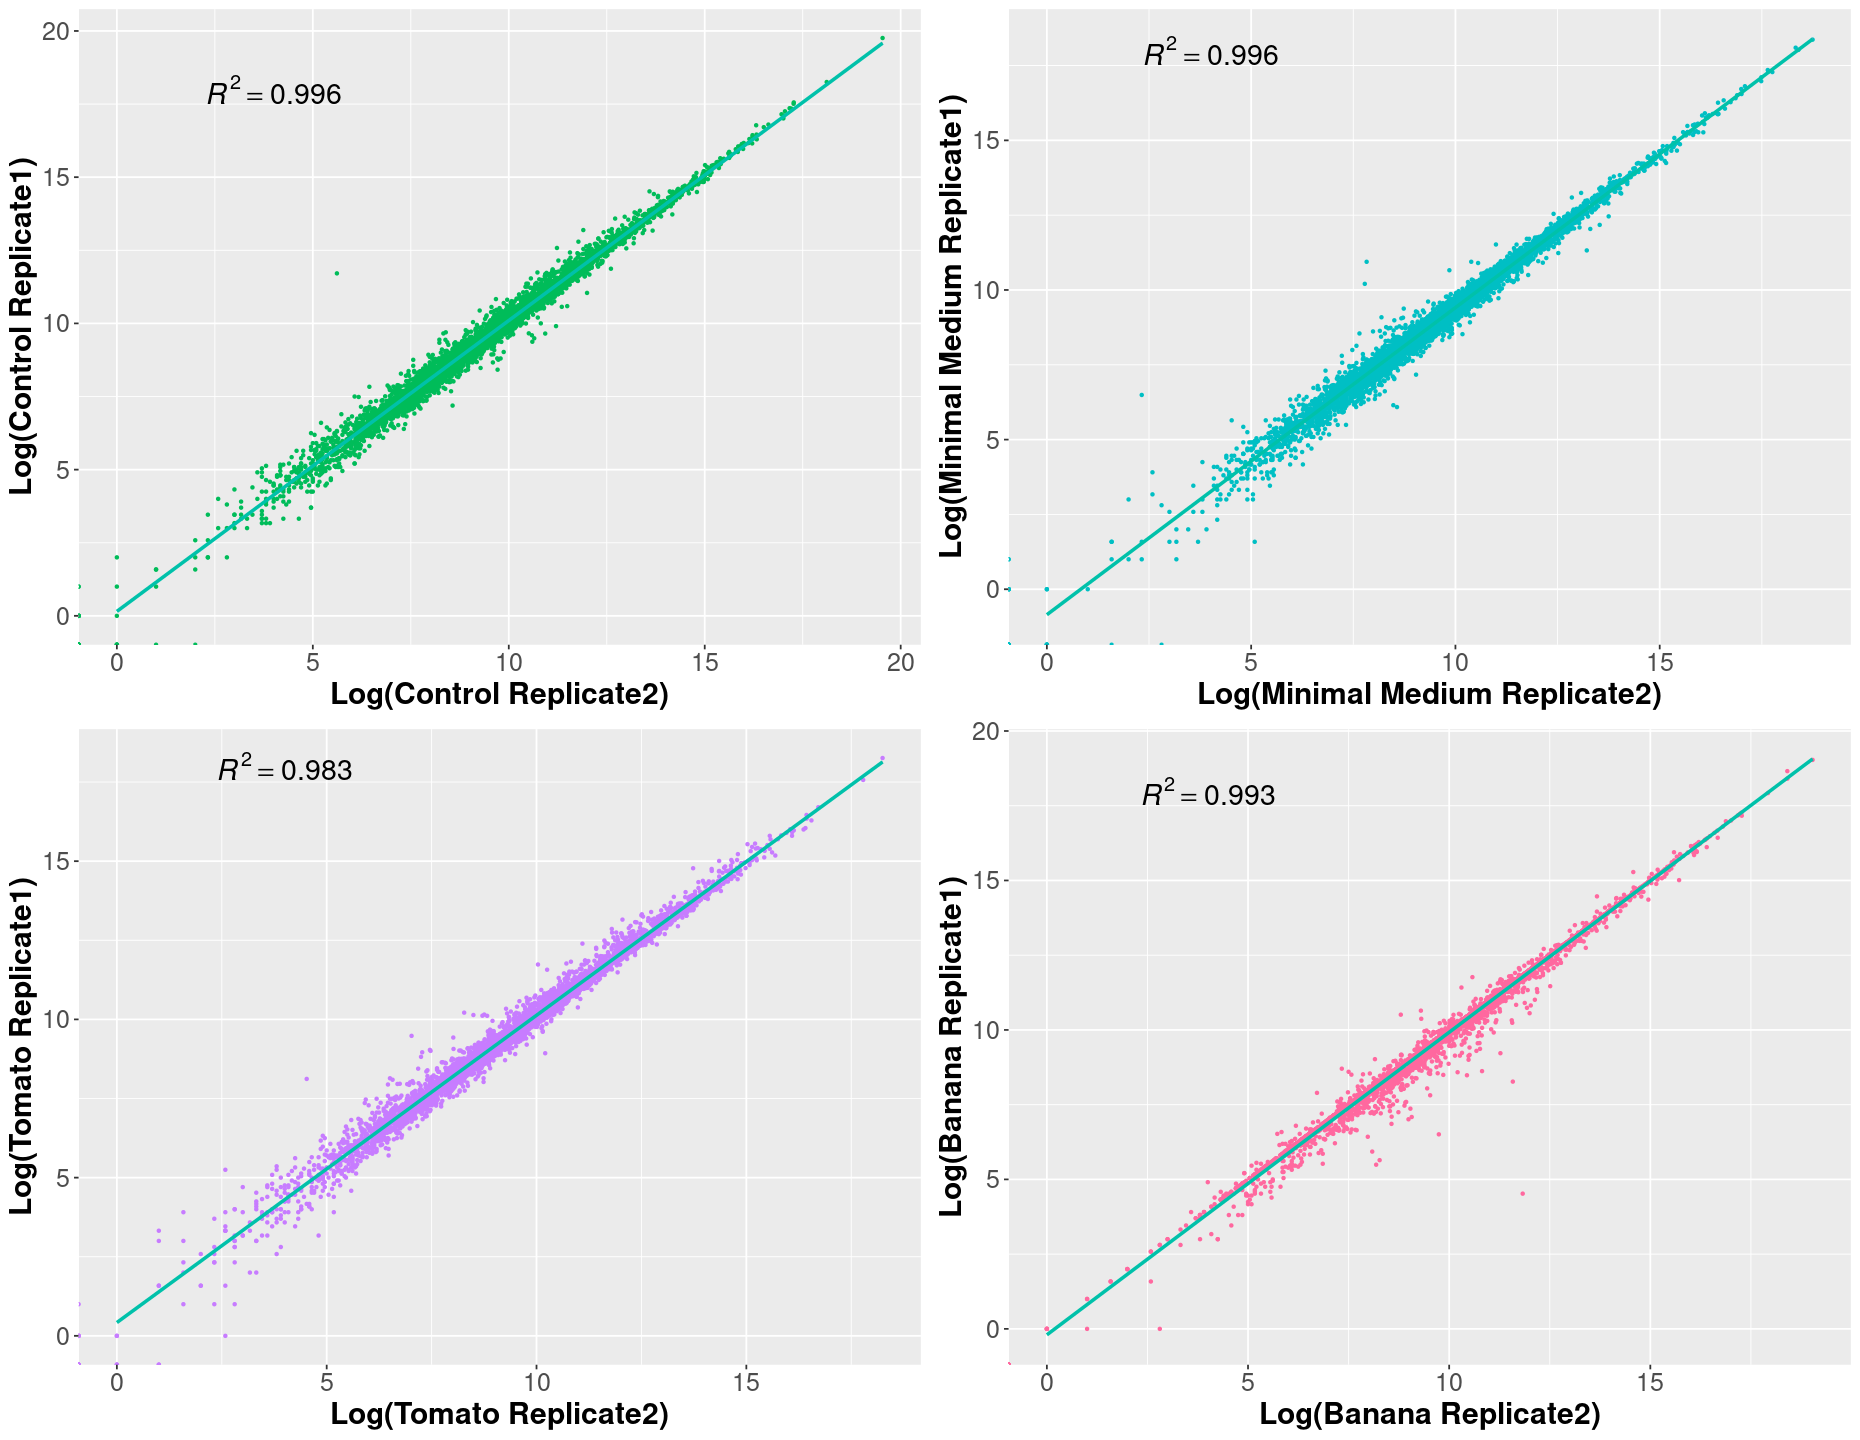

In [14]:
#------------------------------------------------------------#
#---------------------Control Data Regression----------------#
#------------------------------------------------------------#
LmC<-lm(data=Ralstonia_L,Control.R1~Control.R2)
summary(LmC)$r.squared
#------------------------------------------------------------#
#------------------Plot Control Regression-------------------#
#------------------------------------------------------------#
Control <- ggplot(data=Ralstonia_L, aes(x=log2(Control.R1), y=log2(Control.R2))) + 
           geom_point(size=.6, color="#00BC59") + ylab("Log(Control Replicate1)") + My_Theme  + 
           geom_smooth(method=lm, color="#00C1AA", formula = 'y ~ x') + xlab("Log(Control Replicate2)") + 
           annotate("text", x = 4, y =18,size = 6, label ="italic(R) ^ 2 == 0.996", parse=TRUE)

#------------------------------------------------------------#
#------------------Minimal Medium Data Regression------------#
#------------------------------------------------------------#
LmM<-lm(data=Ralstonia_L,Minimal.R1~Minimal.R2)
summary(LmM)$r.squared
#------------------------------------------------------------#
#--------------Plot Minimal Medium Regression----------------#
#------------------------------------------------------------#
Minimal <- ggplot(data=Ralstonia_L, aes(x=log2(Minimal.R1), y=log2(Minimal.R2))) +
           geom_point(size=.6, color="#00BFC4") + ylab("Log(Minimal Medium Replicate1)") + My_Theme + 
           geom_smooth(method=lm, color="#00C1AA", formula = 'y ~ x') + xlab("Log(Minimal Medium Replicate2)") +
           annotate("text", x = 4, y =18,size = 6, label ="italic(R) ^ 2 == 0.996", parse=TRUE)

#------------------------------------------------------------#
#---------------------Banana Data Regression-----------------#
#------------------------------------------------------------#
LmB<-lm(data=Ralstonia_L,Banana.R1~Banana.R2)
summary(LmB)$r.squared
#------------------------------------------------------------#
#------------------Plot Banana Regression--------------------#
#------------------------------------------------------------#
Banana <- ggplot(data=Ralstonia_L, aes(x=log2(Banana.R1), y=log2(Banana.R2))) + 
          geom_point(size=.6, colour="#FF689F") +  My_Theme + ylab("Log(Banana Replicate1)") +
          geom_smooth(method=lm, color="#00C1AA", formula = 'y ~ x') + xlab("Log(Banana Replicate2)") + 
          annotate("text", x = 4, y = 18,size = 6, label = "italic(R) ^ 2 == 0.993", parse=TRUE)

#------------------------------------------------------------#
#---------------------Tomato Data Regression-----------------#
#------------------------------------------------------------#
LmT<-lm(data=Ralstonia_L,Tomato.R1~Tomato.R2)
summary(LmT)$r.squared
#------------------------------------------------------------#
#------------------Plot Tomato Regression--------------------#
#------------------------------------------------------------#
Tomato <- ggplot(data=Ralstonia_L, aes(x=log2(Tomato.R1), y=log2(Tomato.R2))) +
          geom_point(size=.6, colour="#C77CFF") + ylab("Log(Tomato Replicate1)") + My_Theme + 
          geom_smooth(method=lm, color="#00C1AA", formula = 'y ~ x') + xlab("Log(Tomato Replicate2)")+
          annotate("text", x = 4, y =18,size = 6, label = "italic(R) ^ 2 == 0.983", parse=TRUE)

#------------------------------------------------------------#
#-------------Display together Regression's Plot-------------#
#------------------------------------------------------------#
options( warn = -1 )
options(repr.plot.width = 15.5) #Set plot width
options(repr.plot.height = 12)  #Set plot height
suppressWarnings(Dispersion_Plot <- grid.arrange(Control, Minimal, Tomato, Banana, nrow = 2, ncol=2))

### S6. Pearson Correlation Heatmap

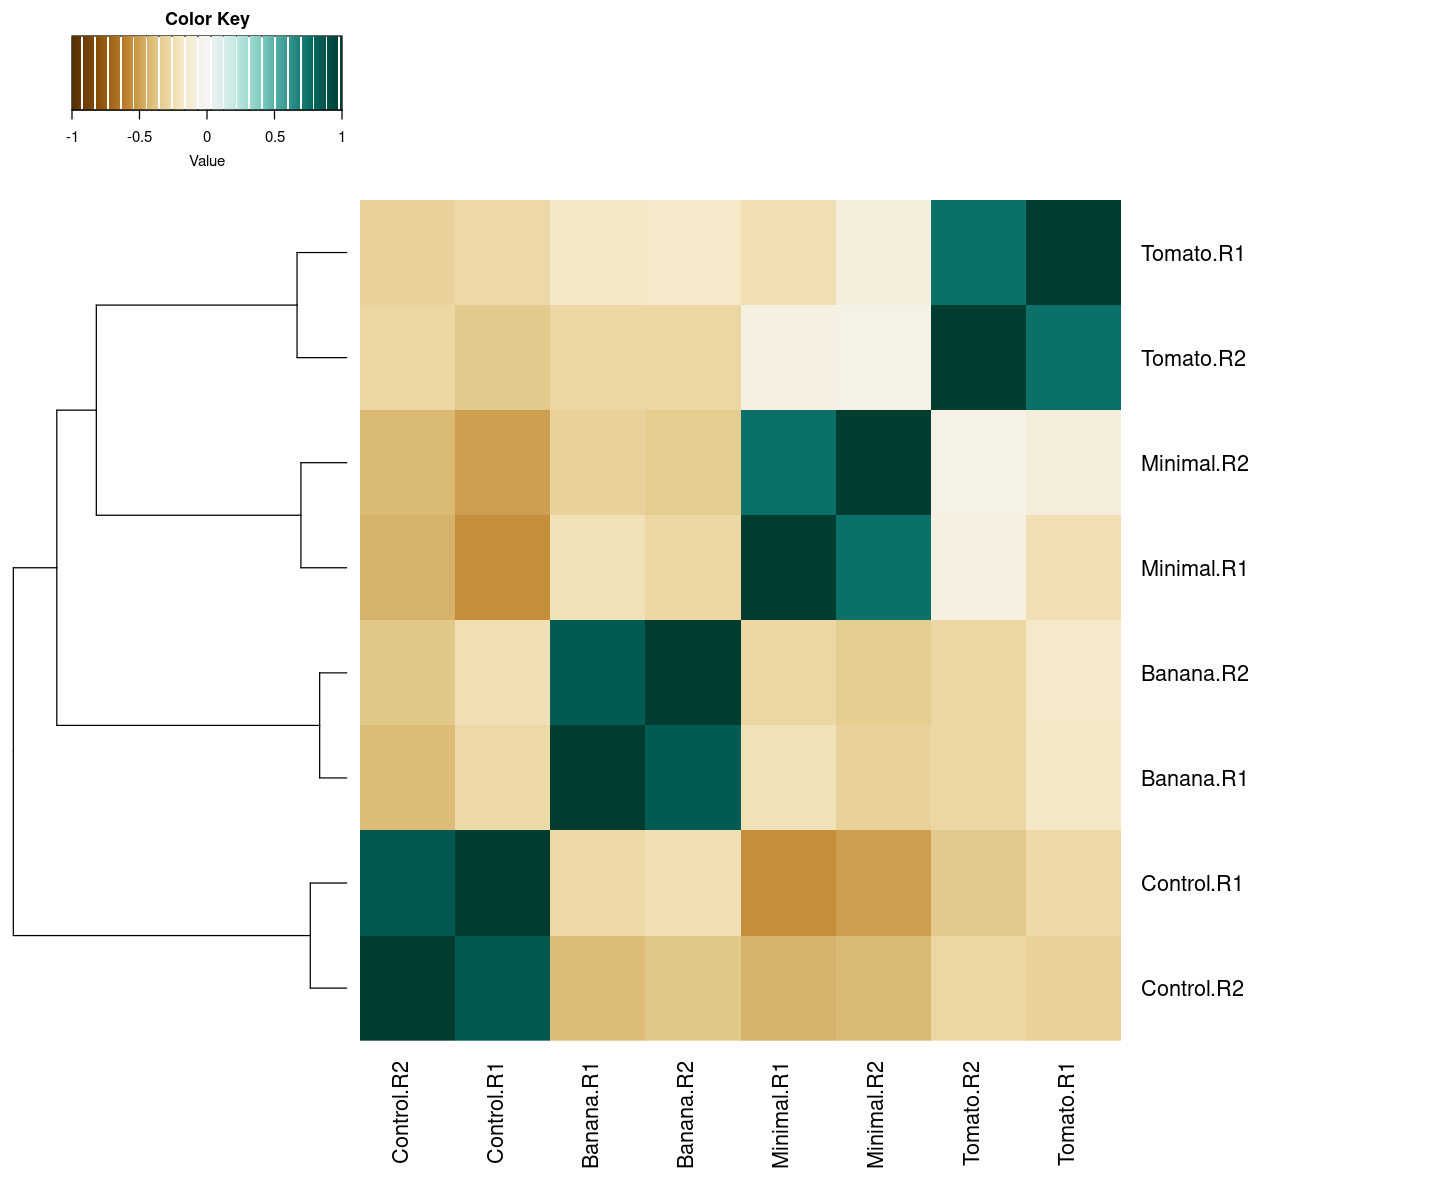

In [23]:
#------------------------------------------------------------#
#------------------------Data heatmap------------------------#
#------------------------------------------------------------#
Ral_z<-t(scale(t(Ralstonia)))
Ral_z2<-na.omit(Ral_z)                # Remove those rows with NAs values on it.
pearson<-cor(Ral_z2,method='pearson') # Pearson correlations
pearson <- pearson[,-9]
pearson <- pearson[-9,]

#------------------------------------------------------------#
#------------------------Plot heatmap------------------------#
#------------------------------------------------------------#
options(repr.plot.width = 12) 
options(repr.plot.height = 10) 
colors<-colorRampPalette(brewer.pal(11,'BrBG'))(200) # Color Palette
heatmap.2(pearson,trace='none',col=colors, scale='none',  
          dendrogram = "row",  key=TRUE,  margins=c(8,16), 
          lwid = c(5,15), lhei = c(3,15), density.info = "none")

### S7. PCA Plot

In [24]:
#------------------------------------------------------------#
#--------------------------Data PCA--------------------------#
#------------------------------------------------------------#
Ral_z<-t(scale(t(Ralstonia)))
Ral_z2<-na.omit(Ral_z) #Remove those rows with NAs values on it.
pca<-prcomp(t(Ral_z2))
pca.data<-data.frame(sample=rownames(pca$x),
                     X=pca$x[,1],
                     Y=pca$x[,2],
                     Group=c(Control='control_1','control_2','Tomato_1','Tomato_2',
                             'Minimal_1','Minimal_2','Banana_1','Banana_2'))
pca.data$title <- "PCA Data"
                  
#------- Calcular los porcentajes de variaci?n por cada PC-------#:
pca.var <- pca$sdev^2
pca.var.per <- round(pca.var/sum(pca.var)*100, 1)

#------------------------------------------------------------#
#--------------------Normalized Data-------------------------#
#------------------------------------------------------------#

Ral_norm_z<-t(scale(t(norm)))
Ral_norm_z2<-na.omit(Ral_norm_z) #Remove those rows with NAs values on it.
#-----------------------PCA-----------------------#:
pca_norm<-prcomp(t(Ral_norm_z2))

pca.data.norm<-data.frame(sample=rownames(pca$x),
                     X=pca_norm$x[,1],
                     Y=pca_norm$x[,2],
                     Group=c(Control='control_1','control_2','Tomato_1',
                             'Tomato_2','Minimal_1','Minimal_2','Banana_1','Banana_2'))
pca.data.norm$title <- "PCA Normalized Data"
                    
#--------------Variation percentage for each PC-------#:
pca.var.norm     <- pca_norm$sdev^2
pca.var.per.norm <- round(pca.var.norm/sum(pca.var.norm)*100, 1)

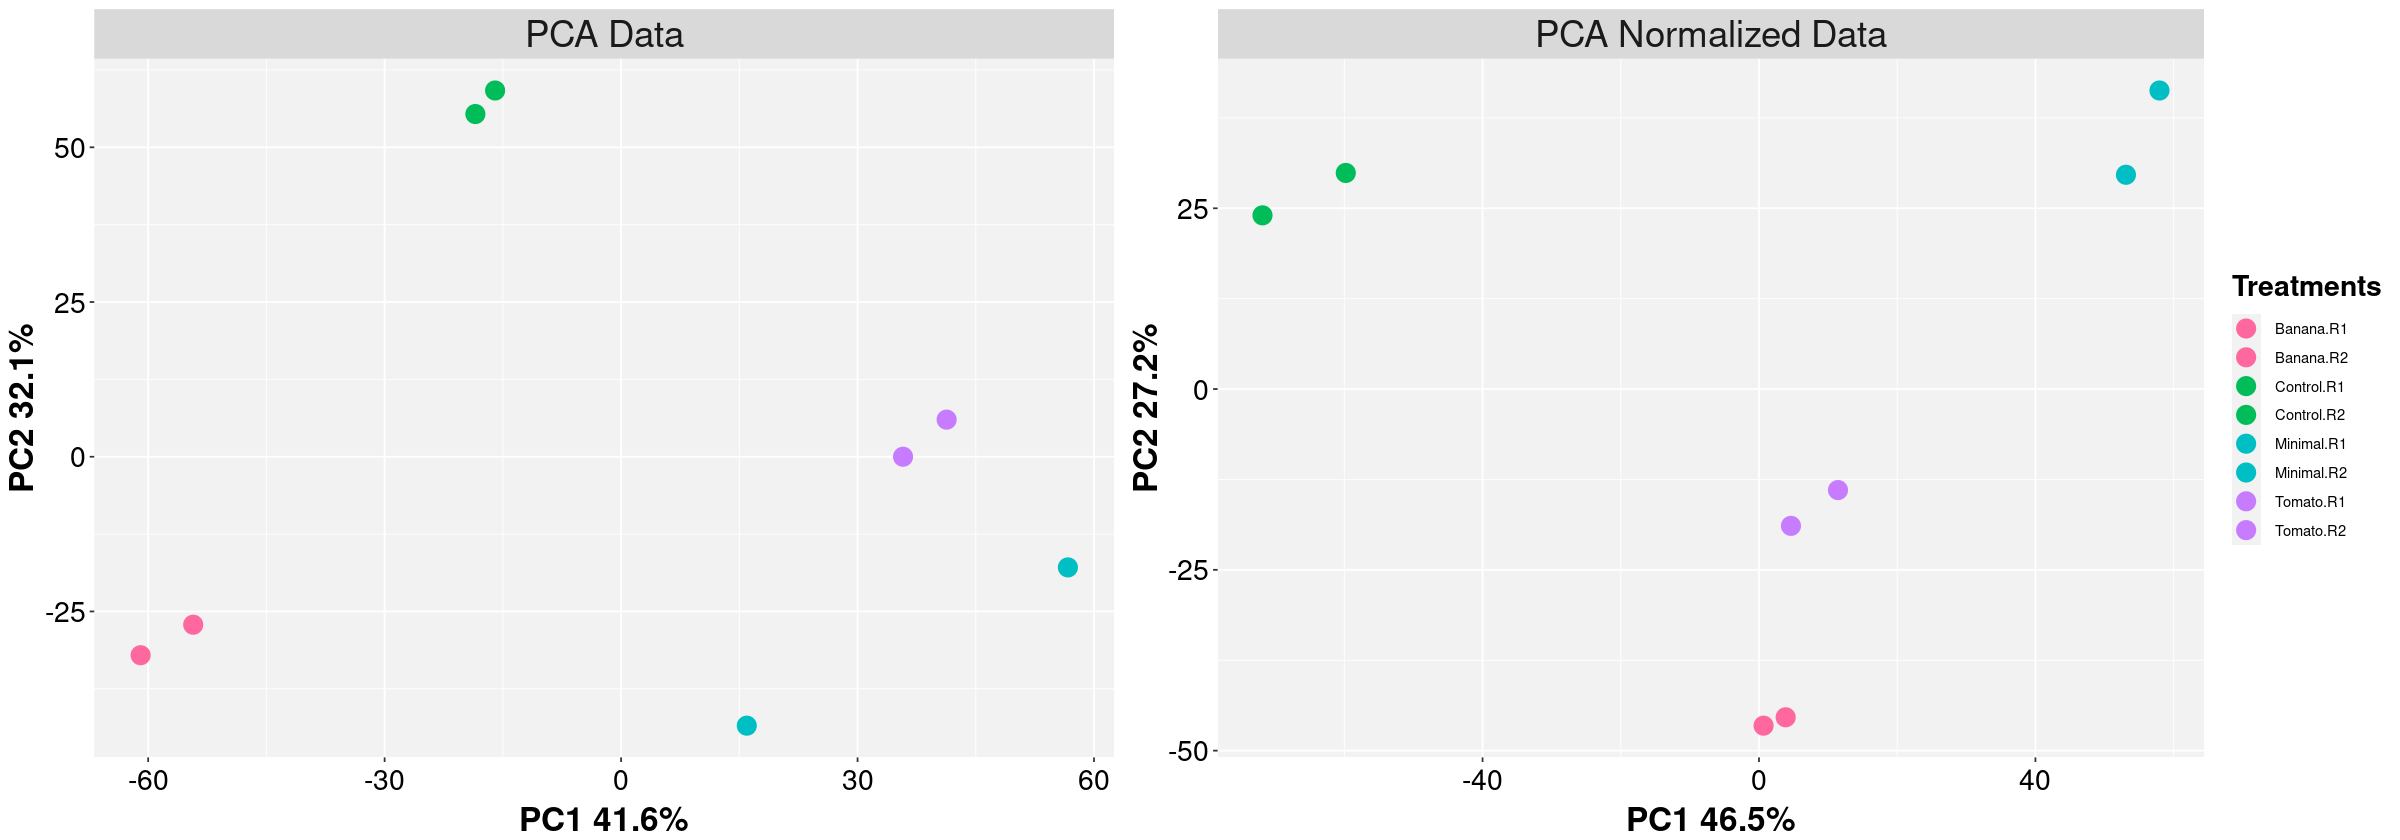

In [26]:
#------------------------------------------------------------#
#------------------Theme of the ggplot-----------------------#
#------------------------------------------------------------#

My_Theme = theme(
  axis.title.x = element_text(size=20, vjust=0.001, face="bold"),
  axis.text.x = element_text(size = 17, color = "black", vjust=0.5),
  axis.title.y =element_text(size=20, vjust=1, face="bold"),
  axis.text.y = element_text(size = 17,color = "black" ),
  strip.text.x= element_text(size = 22),
  panel.background = element_rect(fill = "grey95"))

#------------------------------------------------------------#
#---------------------------Plot PCA-------------------------#
#------------------------------------------------------------#
options(repr.plot.width = 8) 
options(repr.plot.height = 7)
pca_plot <- ggplot(data=pca.data,aes(x=X,y=Y, col=sample))+
            geom_point(size=5)+  xlab(paste("PC1 ",pca.var.per[1],"%",sep="")) + 
            ylab(paste("PC2 ",pca.var.per[2],"%",sep=""))+ My_Theme +
            scale_color_manual(values=c("#FF689F", "#FF689F","#00BC59","#00BC59", 
                                        "#00BFC4","#00BFC4","#C77CFF","#C77CFF" )) +
            facet_grid(. ~ title) + theme(legend.title = element_blank(), legend.position = "none")

#------------------------------------------------------------#
#---------------Plot PCA Normalized Data---------------------#
#------------------------------------------------------------#
options(repr.plot.width = 10) 
options(repr.plot.height = 7) 
pca_norm <- ggplot(data=pca.data.norm,aes(x=X,y=Y, col=sample)) +
            geom_point(size=5)+ xlab(paste("PC1 ",pca.var.per.norm[1],"%",sep="")) +
            ylab(paste("PC2 ",pca.var.per.norm[2],"%",sep="")) + My_Theme +
            guides(color=guide_legend("Treatments"))+
            scale_color_manual(values=c("#FF689F", "#FF689F","#00BC59","#00BC59",
                                        "#00BFC4","#00BFC4","#C77CFF","#C77CFF" )) +
            facet_grid(. ~ title) + theme(legend.title = element_text(size=17, face="bold"))

#------------------------------------------------------------#
#-------------Display two PCA Plots together ----------------#
#------------------------------------------------------------#
options(repr.plot.width = 20) 
options(repr.plot.height = 7) 
PCA_Plot <- grid.arrange(pca_plot, pca_norm, nrow = 1, ncol=2, widths = c(8.8, 10))

### 4. Diferential Expression Analysis

### S8. DEGs DIspersion

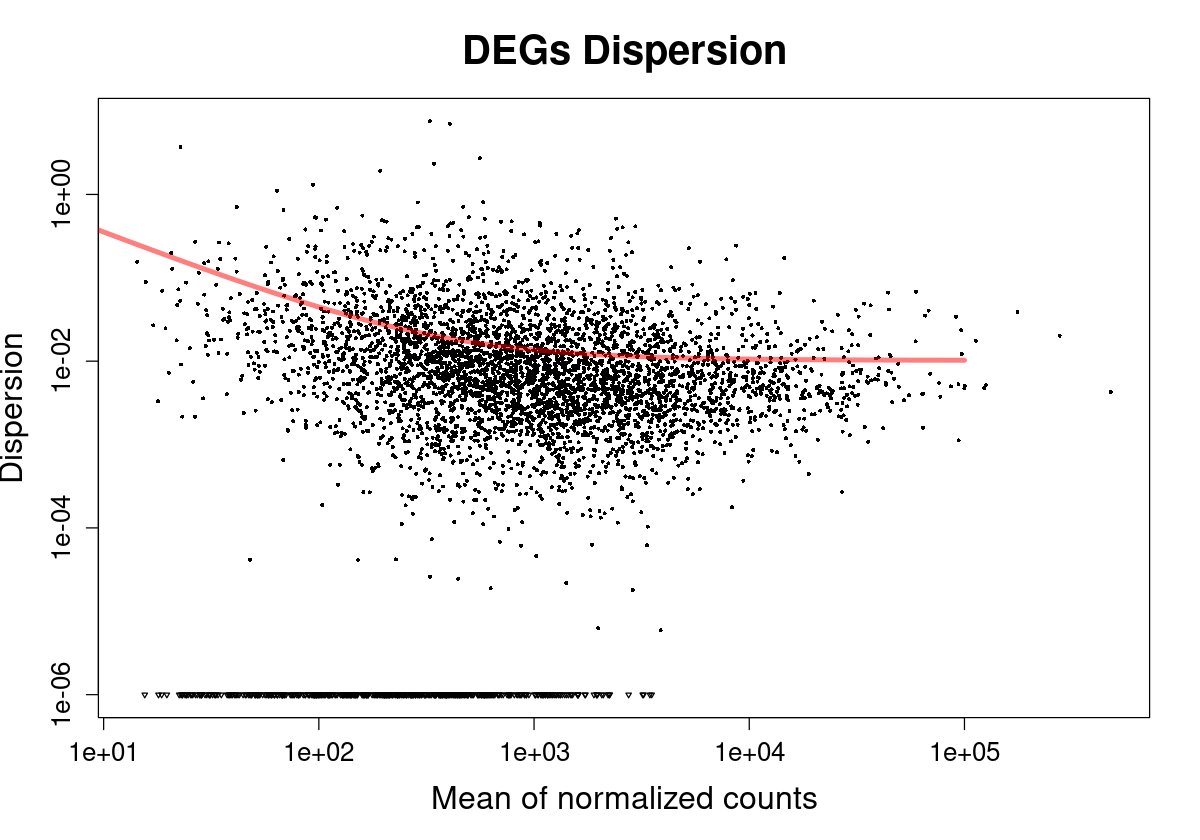

In [27]:
#------------------------------------------------------------#
#-------------------- Estimate overall dispersion------------#
#------------------------------------------------------------#
cds <- estimateDispersions(cds) 

#------------------------------------------------------------#
#--------------------Dispersion Plor-------------------------#
#------------------------------------------------------------#
options(repr.plot.width = 10) 
options(repr.plot.height = 7) 
DESeq::plotDispEsts(cds, xlab = "Mean of normalized counts", ylab="Dispersion",
      cex.lab=1.6,cex.axis=1.3)
title("DEGs Dispersion", cex.main=2)

### S9. MA-Plots 

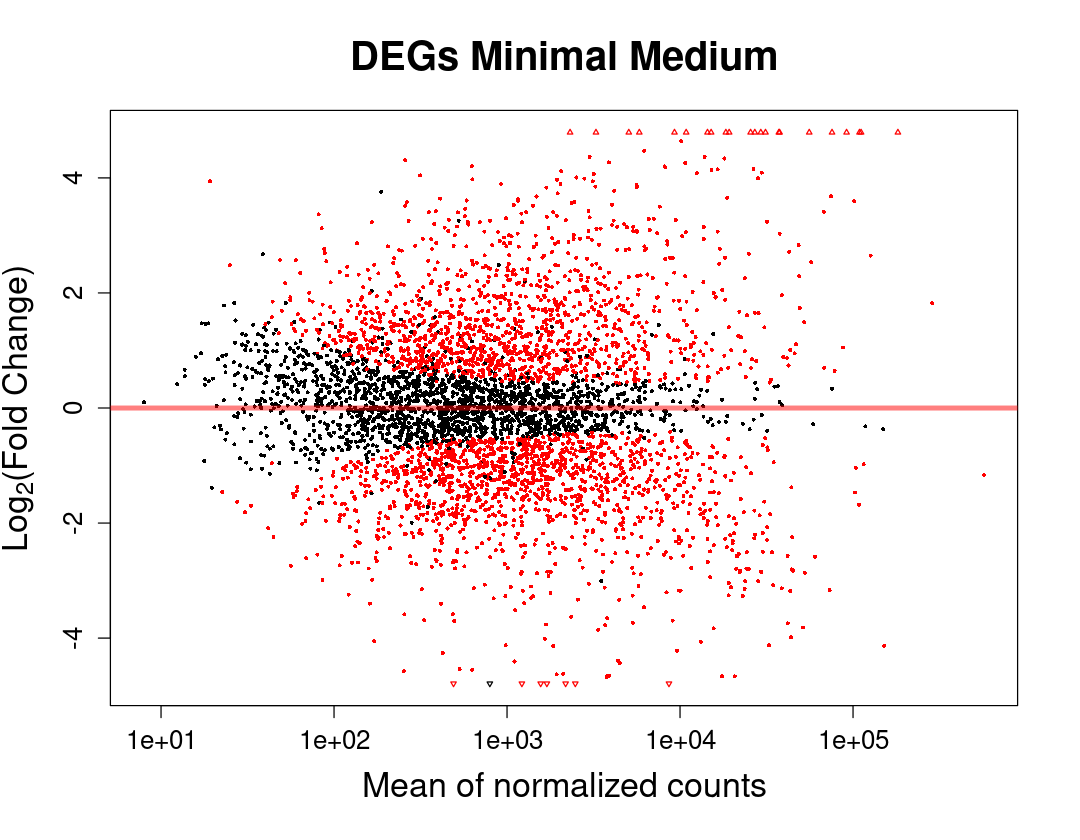

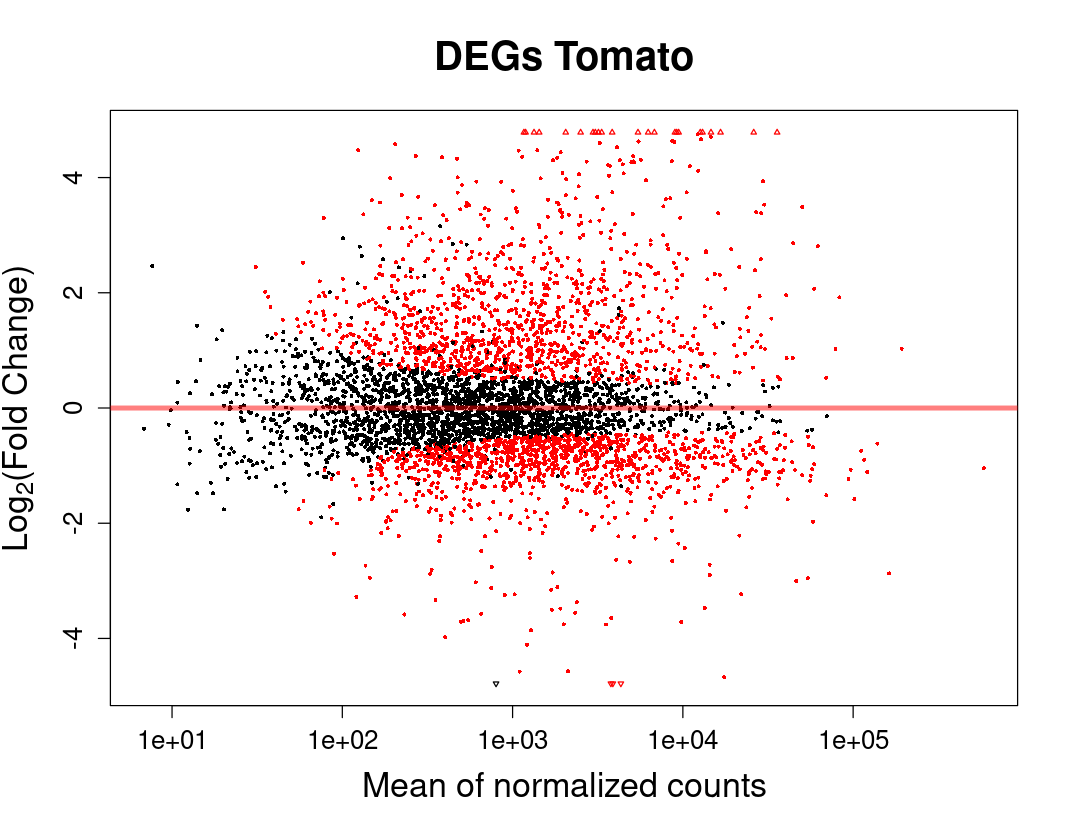

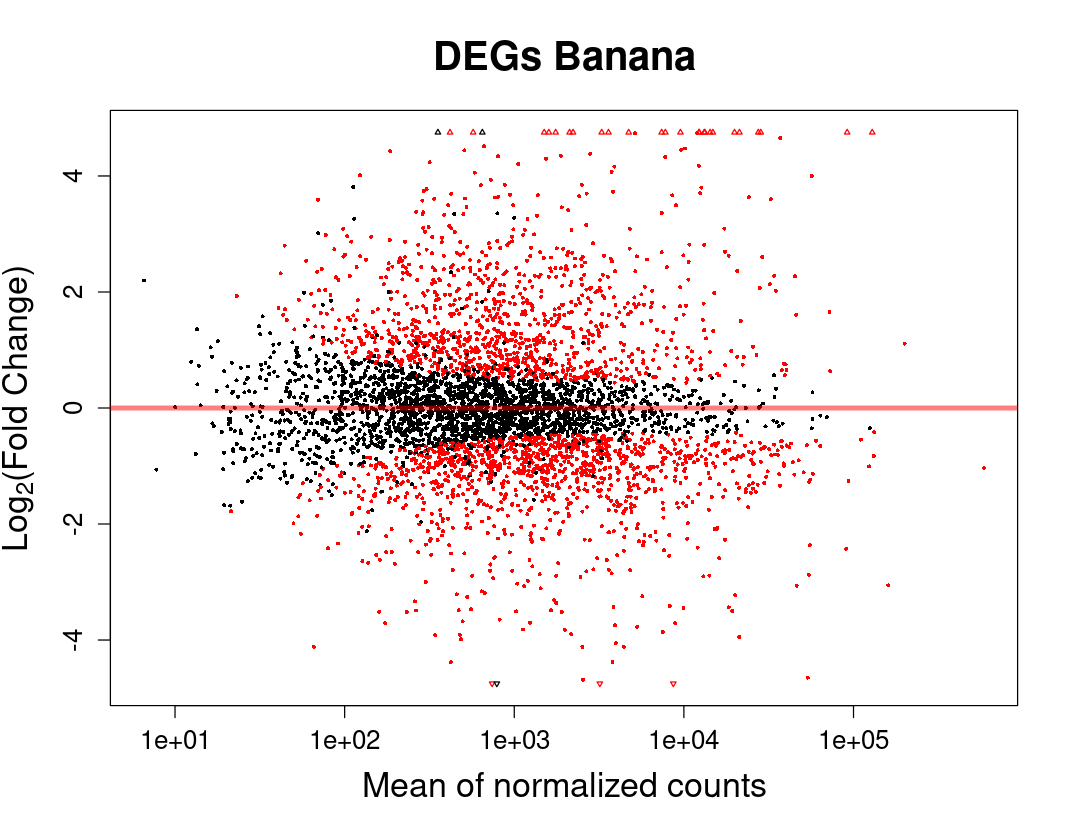

In [28]:
#------------------------------------------------------------#
#----------------------Obtain DEGs---------------------------#
#------------------------------------------------------------#
degs_T<-nbinomTest( cds, "Control", "Tomato")
degs_B<-nbinomTest( cds, "Control", "Banana")
degs_M<-nbinomTest( cds, "Control", "Minimal")
degs_T$title <- "DEGs Tomato" 
degs_B$title <- "DEGs Banana" 
degs_M$title <- "DEGs Minimal Medium"

#------------------------------------------------------------#
#--------------------- Parameter Plot------------------------#
#------------------------------------------------------------#
options(repr.plot.width = 9) 
options(repr.plot.height = 7) 
par(mai=c(1.0,0.8,0.8,0.4)+0.01, mar=c(5,4,4,2)+0.6)
#------------------------------------------------------------#
#-------------------- Minimal MA Plot------------------------#
#------------------------------------------------------------#
plotM <- plotMA(degs_M,col = ifelse(degs_M$padj>=0.01, "black", "red"), cex.lab=1.7,cex.axis=1.3,
         xlab = "Mean of normalized counts", ylab=expression(paste(Log[2],"(Fold Change)")))
title("DEGs Minimal Medium", cex.main=2)

#------------------------------------------------------------#
#-------------------- Tomato MA Plot-------------------------#
#------------------------------------------------------------#
plotT <- plotMA(degs_T,col = ifelse(degs_T$padj>=0.01, "black", "red"), cex.lab=1.7,cex.axis=1.3,
         xlab = "Mean of normalized counts", ylab=expression(paste(Log[2],"(Fold Change)")))
title("DEGs Tomato",cex.main=2)

#------------------------------------------------------------#
#-------------------- Banana MA Plot-------------------------#
#------------------------------------------------------------#
plotB <- plotMA(degs_B,col = ifelse(degs_B$padj>=0.01, "black", "red"), 
         xlab = "Mean of normalized counts", ylab=expression(paste(Log[2],"(Fold Change)")),
         cex.lab=1.7,cex.axis=1.3)
title("DEGs Banana",cex.main=2)

### S10. DEGs Histogram 

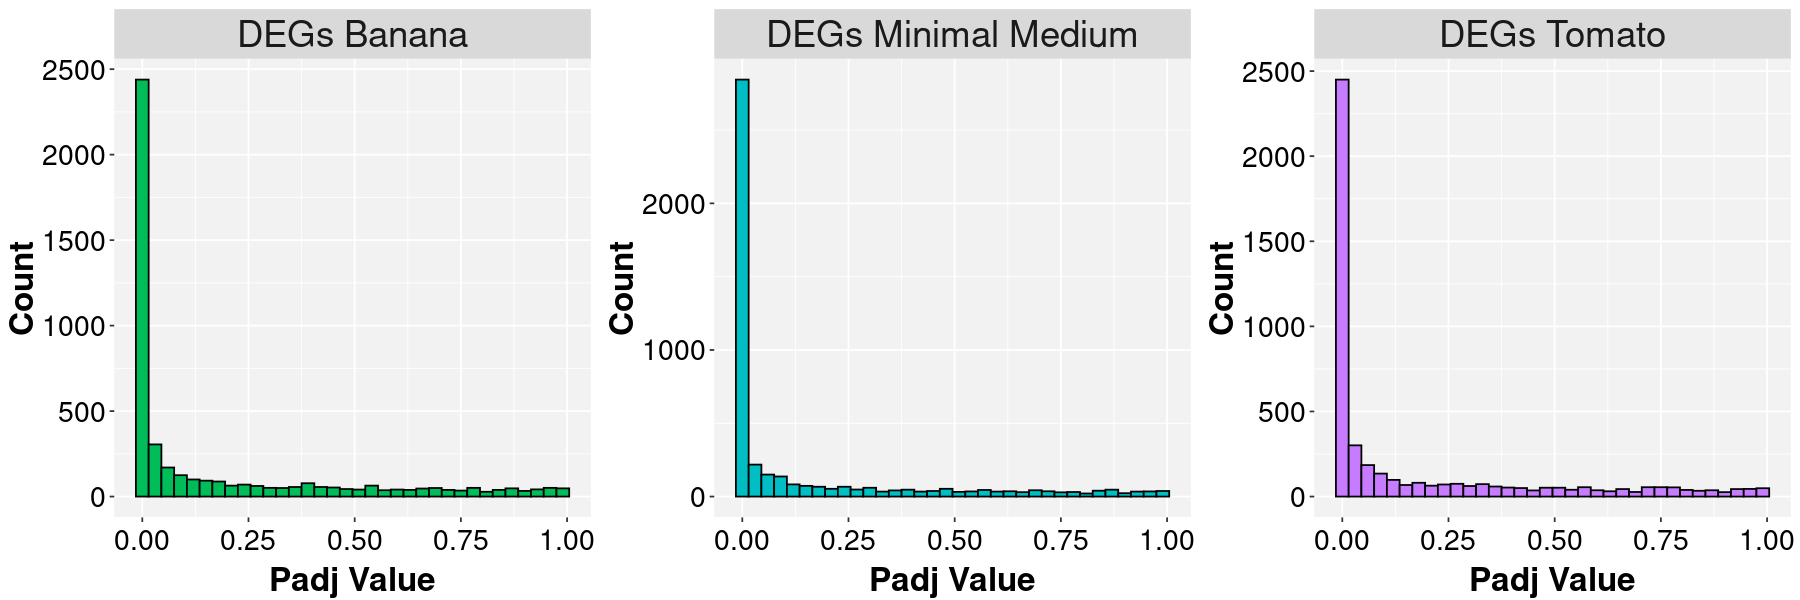

In [29]:
#------------------------------------------------------------#
#------------------Theme of the ggplot-----------------------#
#------------------------------------------------------------#
My_Theme = theme(
  axis.title.x = element_text(size=20, vjust=0.001, face="bold"),
  axis.text.x = element_text(size = 17, color = "black", vjust=0.5),
  axis.title.y =element_text(size=20, vjust=1, face="bold"),
  axis.text.y = element_text(size = 17,color = "black" ),
  strip.text.x= element_text(size = 22),
  panel.background = element_rect(fill = "grey95"))

#------------------------------------------------------------#
#------------------Plot Histogram----------------------------#
#------------------------------------------------------------#

Plotdegs_B <- ggplot(degs_B, aes(x=padj)) + My_Theme +
              geom_histogram(binwidth =0.03, stat = "bin", color="black", fill="#00BC59") +
              ylab("Count") + xlab("Padj Value") +
              facet_grid(. ~ title) + theme (legend.title = element_text(size=17, face="bold"))

Plotdegs_M <- ggplot(degs_M, aes(x=padj)) + My_Theme +
              geom_histogram(binwidth =0.03, stat = "bin", color="black", fill="#00BFC4") +
              ylab("Count") + xlab("Padj Value") +
              facet_grid(. ~ title) + theme (legend.title = element_text(size=17, face="bold"))

Plotdegs_T <- ggplot(degs_T, aes(x=padj)) + My_Theme +
              geom_histogram(binwidth =0.03, stat = "bin", color="black", fill="#C77CFF" ) +
              ylab("Count") + xlab("Padj Value") +
              facet_grid(. ~ title) + theme (legend.title = element_text(size=17, face="bold"))

#------------------------------------------------------------#
#------------Display Histograms Plots together --------------#
#------------------------------------------------------------#
options(repr.plot.width = 15)  
options(repr.plot.height = 5)
grid.arrange(Plotdegs_B, Plotdegs_M, Plotdegs_T, widths = c(5,5,5))

#### DEGs Analysis

In [30]:
#-----------------------------------------------------------------------#
#-------------Filtering DEGs log2FC >|0.6| and p.adj< 0.05--------------#
#-----------------------------------------------------------------------#
Desig_T <- subset.data.frame(degs_T, padj<0.05 & abs(log2FoldChange)>0.6)
write.table(Desig_T, file="Genes_Tomato") #Save data.frame
Desig_B <- subset.data.frame(degs_B, padj<0.05 & abs(log2FoldChange)>0.6)
write.table(Desig_B, file="Genes_Banana") #Save data.frame
Desig_M <- subset.data.frame(degs_M, padj<0.05 & abs(log2FoldChange)>0.6)
write.table(Desig_M, file="Genes_Minimal") #Save data.frame

#-----------------------------------------------------------------------#
#-------------Filtering Ups DEGs log2FC > 0.6 and p.adj< 0.05-----------#
#-----------------------------------------------------------------------#
Up_T <- subset.data.frame(degs_T, padj<0.05 & log2FoldChange>0.6)
write.table(Up_T, file="DEGs_Tomato_Up") #Save data.frame
Up_B <- subset.data.frame(degs_B, padj<0.05 & log2FoldChange>0.6)
write.table(Up_B, file="DEGs_Banana_Up") #Save data.frame
Up_M <- subset.data.frame(degs_M, padj<0.05 & log2FoldChange>0.6)

#-----------------------------------------------------------------------#
#------------Filtering Downs DEGs log2FC < 0.6 and p.adj< 0.05----------#
#-----------------------------------------------------------------------#
Down_T <- subset.data.frame(degs_T, padj<0.05 & log2FoldChange<(-0.6))
write.table(Down_T, file="DEGs_Tomato_Down") #Save data.frame
Down_B <- subset.data.frame(degs_B, padj<0.05 & log2FoldChange<(-0.6))
write.table(Down_B, file="DEGs_Banana_Down") #Save data.frame
Down_M <- subset.data.frame(degs_M, padj<0.05 & log2FoldChange<(-0.6))

In [31]:
#-----------------------------------------------------------------------#
#---------------------- DEGs with normalized counts---------------------#
#-----------------------------------------------------------------------#
list= Desig_B['id'][,]
normalizedcounts_filterB=as.data.frame(norm)[list, ]
write.table(normalizedcounts_filterB, file="DEGs_banana")

list= Desig_T['id'][,]
normalizedcounts_filterT=as.data.frame(norm)[list, ]
write.table(normalizedcounts_filterT, file="DEGs_Tomato")

list= Desig_M['id'][,]
normalizedcounts_filterM=as.data.frame(norm)[list, ]
write.table(normalizedcounts_filterM, file="DEGs_Minimal")

#-----------------------------------------------------------------------#
#-----------------Downs DEGs with normalized counts---------------------#
#-----------------------------------------------------------------------#
list= Down_B['id'][,]
normalizedcounts_filterBDown=as.data.frame(norm)[list, ]
write.table(normalizedcounts_filterBDown, file="DEGs_Down_banana")

list= Down_T['id'][,]
normalizedcounts_filterTDown=as.data.frame(norm)[list, ]
write.table(normalizedcounts_filterTDown, file="DEGs_Down_Tomato")

list= Down_M['id'][,]
normalizedcounts_filterMDown=as.data.frame(norm)[list, ]
write.table(normalizedcounts_filterMDown, file="DEGs_Down_Minimal")

#-----------------------------------------------------------------------#
#--------------------Ups DEGs with normalized counts--------------------#
#-----------------------------------------------------------------------#
list= Up_B['id'][,]
normalizedcounts_filterBUp=as.data.frame(norm)[list, ]
write.table(normalizedcounts_filterBUp, file="DEGs_Up_banana")

list= Up_T['id'][,]
normalizedcounts_filterTUp=as.data.frame(norm)[list, ]
write.table(normalizedcounts_filterTUp, file="DEGs_Up_Tomato")

list= Up_M['id'][,]
normalizedcounts_filterMUp=as.data.frame(norm)[list, ]
write.table(normalizedcounts_filterMUp, file="DEGs_Up_Minimal")

### F1. Vennyplot

https://bioinfogp.cnb.csic.es/tools/venny/

**A**: Ups DEGs
**B**: Downs DEGs

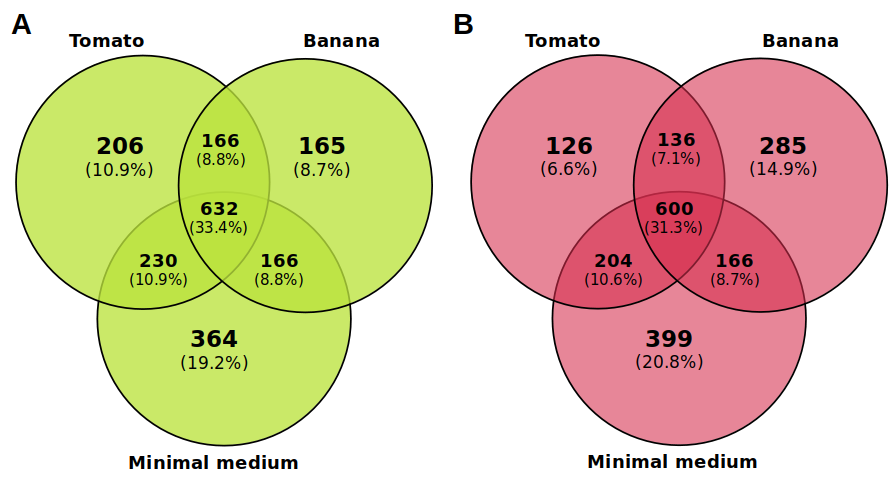

In [32]:
display_png(file="Vennyplot.png")

### Barplot GO Terms

### F2.A. Heatmap

In [42]:
venny <- read.table('Down_UP_Unique_shared',sep='\t',header=T)

#------------------------------------------------------------#
#------------------------Data Share--------------------------#
#------------------------------------------------------------#

#---------List containing Ups-Downs shared DEGs's IDs--------#
shared_ups   <- as.character(venny$UP_shared)
shared_downs <- as.character(venny$Down_Shared)
norm_shared_ups <- as.data.frame(norm)[shared_ups, ]
norm_shared_downs <- as.data.frame(norm)[shared_downs, ]
norm_shared_downs <- na.omit(norm_shared_downs)
#---------------------------Scale----------------------------#
Norm_shared_Ups_Z <- t(scale(t(norm_shared_ups))) 
Norm_shared_Downs_Z<-t(scale(t(norm_shared_downs))) 
write.table (Norm_shared_Ups_Z, file="Norm_shared_Ups.txt")
write.table (Norm_shared_Downs_Z, file="Norm_shared_Downs.txt")


#------------------------------------------------------------#
#-------------------------Data Banana------------------------#
#------------------------------------------------------------#
#---------List containing Ups-Downs shared DEGs's IDs--------#
banana_ups <- as.character(venny$UP_Banana)
banana_downs <- as.character(venny$Down_Banana)
norm_banana_downs<-as.data.frame(norm)[banana_downs, ]
norm_banana_ups<-as.data.frame(norm)[banana_ups, ]
norm_banana_ups<-na.omit(norm_banana_ups)
#---------------------------Scale----------------------------#
Norm_banana_Ups_Z <- t(scale(t(norm_banana_ups))) 
Norm_banana_Downs_Z <- t(scale(t(norm_banana_downs))) 
write.table (Norm_banana_Ups_Z, file="Norm_banana_Ups.txt")
write.table (Norm_banana_Downs_Z, file="Norm_banana_Downs.txt")


#------------------------------------------------------------#
#------------------------Data Tomato-------------------------#
#------------------------------------------------------------#
#---------List containing Ups-Downs shared DEGs's IDs--------#
tomato_ups<-as.character(venny$Up_Tomato)
tomato_downs<-as.character(venny$Down_Tomato)
norm_tomato_downs<-as.data.frame(norm)[tomato_downs, ]
norm_tomato_ups<-as.data.frame(norm)[tomato_ups, ] 
norm_tomato_ups<-na.omit(norm_tomato_ups)
#---------------------------Scale----------------------------#
Norm_tomato_Ups_Z<-t(scale(t(norm_tomato_ups))) 
Norm_tomato_Downs_Z<-t(scale(t(norm_tomato_downs))) 
write.table (Norm_tomato_Ups_Z, file="Norm_tomato_Ups.txt")
write.table (Norm_tomato_Downs_Z, file="Norm_tomato_Downs.txt")

In [ ]:
options(repr.plot.width = 9)
options(repr.plot.height = 12)

heat_shared  <-read.table("MEAN_Shared",header=T,sep="\t",row.names=1)
heat_shared  <- as.matrix(heat_shared[1:4]) 
heat_shared  <- as.matrix(heat_shared)
heat_shared2 <- heatmap.2(heat_shared,trace='none',col=magma, scale='none', Colv=T, dendrogram="column", key=TRUE, 
               margins=c(8,18), lwid = c(5,16),lhei = c(3,16), density.info = "none", labRow="",key.xlab="Z-score")

heat_banana  <-read.table("MEAN_Banana",header=T,sep="\t",row.names=1)
heat_banana  <- as.matrix(heat_banana[1:4]) 
heat_banana  <-as.matrix(heat_banana)
heat_banana2 <- heatmap.2(heat_banana,trace='none',col=magma, scale='none', Colv=T, dendrogram="column", key=F, 
                margins=c(8,18),lwid = c(5,16), lhei = c(3,16), density.info = "none", labRow="")

heat_tomato  <- read.table("MEAN_Tomato",header=T,sep="\t",row.names=1)
heat_tomato  <- as.matrix(heat_tomato[1:4]) 
heat_tomato  <- as.matrix(heat_tomato)
heat_tomato2 <- heatmap.2(heat_tomato,trace='none',col=magma, scale='none', Colv=T, dendrogram="column", key=T, 
               margins=c(8,18),lwid = c(5,16), lhei = c(3,16), density.info = "none", labRow="")

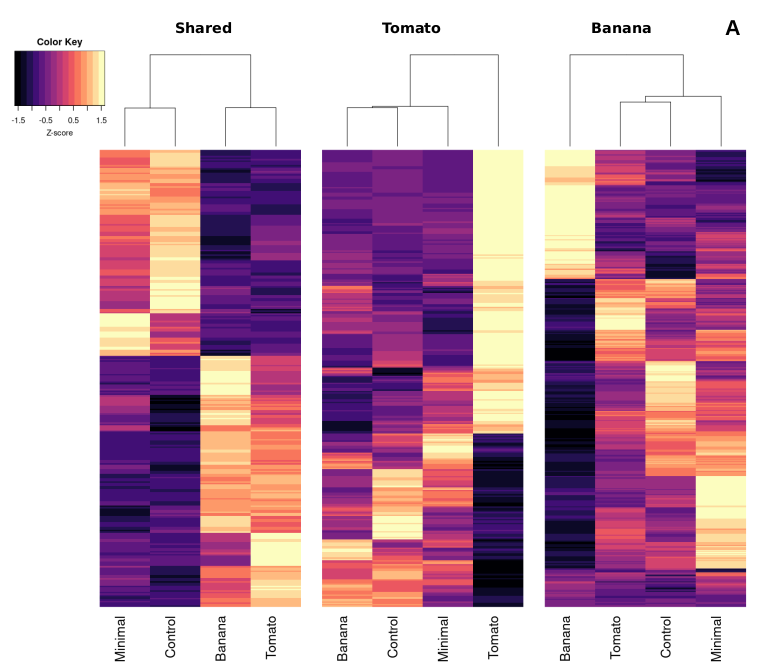

In [50]:
display_png(file="Heatmap.png")

### F2. (B) Matplotting  -  (C) Scatterplot

In [ ]:
#-------------------------------------------------------------#
#-----------------List Shared genes Ups and Downs-------------#
#-------------------------------------------------------------#
shared_ups  <-as.character(venny$UP_shared)
shared_downs<-as.character(venny$Down_Shared)

#------------Normalize Shared genes Ups and Downs-------------#
Norm_shared_ups  <-as.data.frame(norm)[shared_ups,] 
Norm_shared_downs<-as.data.frame(norm)[shared_downs,]
list_1 <-row.names(Filtered_Ral) # Filtered genes IDs 
pass   <-as.data.frame(Ralstonia_L)[list_1, ] #Just filtered genes


sups<-as.data.frame(pass)[shared_ups, ]     # shared Ups with length.
sdowns<-as.data.frame(pass)[shared_downs, ] # shared Downs with length.
sups<-na.omit(sups)     # Omitting NAs
sdowns<-na.omit(sdowns) # Omiting NAs

#-------------------------------------------------------------#
#-------------Obtaining TPM from Shared DEGs------------------#
#-------------------------------------------------------------#

#Function by: https://gist.github.com/slowkow/6e34ccb4d1311b8fe62e
tpm <- function(counts, lengths){ 
  rate <- counts / lengths
  rate / sum(rate) * 1e6        }  

tpm_ups <- log2(apply(sups[2:9], 2, function(x) tpm(x, sups$Length)))
tpm_downs <- log2(apply(sdowns[2:9], 2, function(x) tpm(x, sdowns$Length)))
write.table(tpm_ups, file="tpms_ups")
write.table(tpm_downs, file="tpms_downs")

#-------------------------------------------------------------#
#----------Obtaining values from Shared DEGs------------------#
#-------------------------------------------------------------#
shaups_B  <-read.table('DEGs_Banana_Up',header=T,row.names="id")    # Ups DEGs in Banana
shadowns_B<-read.table('DEGs_Banana_Down',header=T,row.names="id")  # Downs DEGs in Banana
shaups_T  <-read.table('DEGs_Tomato_Up',header=T,row.names="id")    # Ups DEGs in Tomato
shadowns_T<-read.table('DEGs_Tomato_Down',header=T,row.names="id")  # Downs DEGs in Tomato

shared_ups_onB<-as.data.frame(shaups_B)[(shared_ups), ] 
write.table(shared_ups_onB, file="shared_ups_onB") 

shared_downs_onB<-as.data.frame(shadowns_B)[(shared_downs), ] 
write.table(shared_downs_onB, file="shared_downs_onB") 

shared_ups_onT<-as.data.frame(shaups_T)[shared_ups, ]
write.table(shared_ups_onT, file="shared_ups_onT") 

shared_downs_onT<-as.data.frame(shadowns_T)[shared_downs, ]
write.table(shared_downs_onT, file="shared_downs_onT")

In [1]:
#-------------------------------------------------------------#
#----------------------------Data-----------------------------#
#-------------------------------------------------------------#
MatPlot <- read.table('MatPlot',sep='\t',header=T)
head(MatPlot)

,Genes,TPM,Log2FC,Origin,Class
,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,UW163_00280,12.497761,1.6299152,Tomato,up
2,UW163_00440,10.331802,0.7256703,Tomato,up
3,UW163_00475,11.165270,1.0024802,Tomato,up
4,UW163_01270,8.357994,1.5407006,Tomato,up
5,UW163_01295,10.133251,0.8033366,Tomato,up
6,UW163_01345,8.647162,0.9648168,Tomato,up


In [7]:
#-------------------------------------------------------------#
#-----------------------------Data----------------------------#
#-------------------------------------------------------------#
venny <- read.table('Down_UP_Unique_shared',sep='\t',header=T)
head(venny)

,Up_Tomato,UP_Banana,UP_shared,Down_Tomato,Down_Banana,Down_Shared
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,UW163_00115,UW163_00105,UW163_00280,UW163_00260,UW163_00310,UW163_00225
2,UW163_00340,UW163_00520,UW163_00440,UW163_00445,UW163_00555,UW163_00655
3,UW163_00455,UW163_00525,UW163_00475,UW163_00780,UW163_00645,UW163_00975
4,UW163_00460,UW163_00535,UW163_01270,UW163_00885,UW163_00650,UW163_00995
5,UW163_00485,UW163_00965,UW163_01295,UW163_01115,UW163_00675,UW163_01625
6,UW163_00500,UW163_01200,UW163_01345,UW163_01210,UW163_00685,UW163_02010


In [2]:
Scatter <- read.table('Scatter',sep='\t',header=T)
head(Scatter)

,Genes,Log2FC_T,Log2FC_B,Class
,<fct>,<dbl>,<dbl>,<fct>
1,UW163_00280,1.6299152,2.8378738,Up
2,UW163_00440,0.7256703,2.1145440,Up
3,UW163_00475,1.0024802,0.9494960,Up
4,UW163_01270,1.5407006,2.0308870,Up
5,UW163_01295,0.8033366,1.6118347,Up
6,UW163_01345,0.9648168,0.7875079,Up


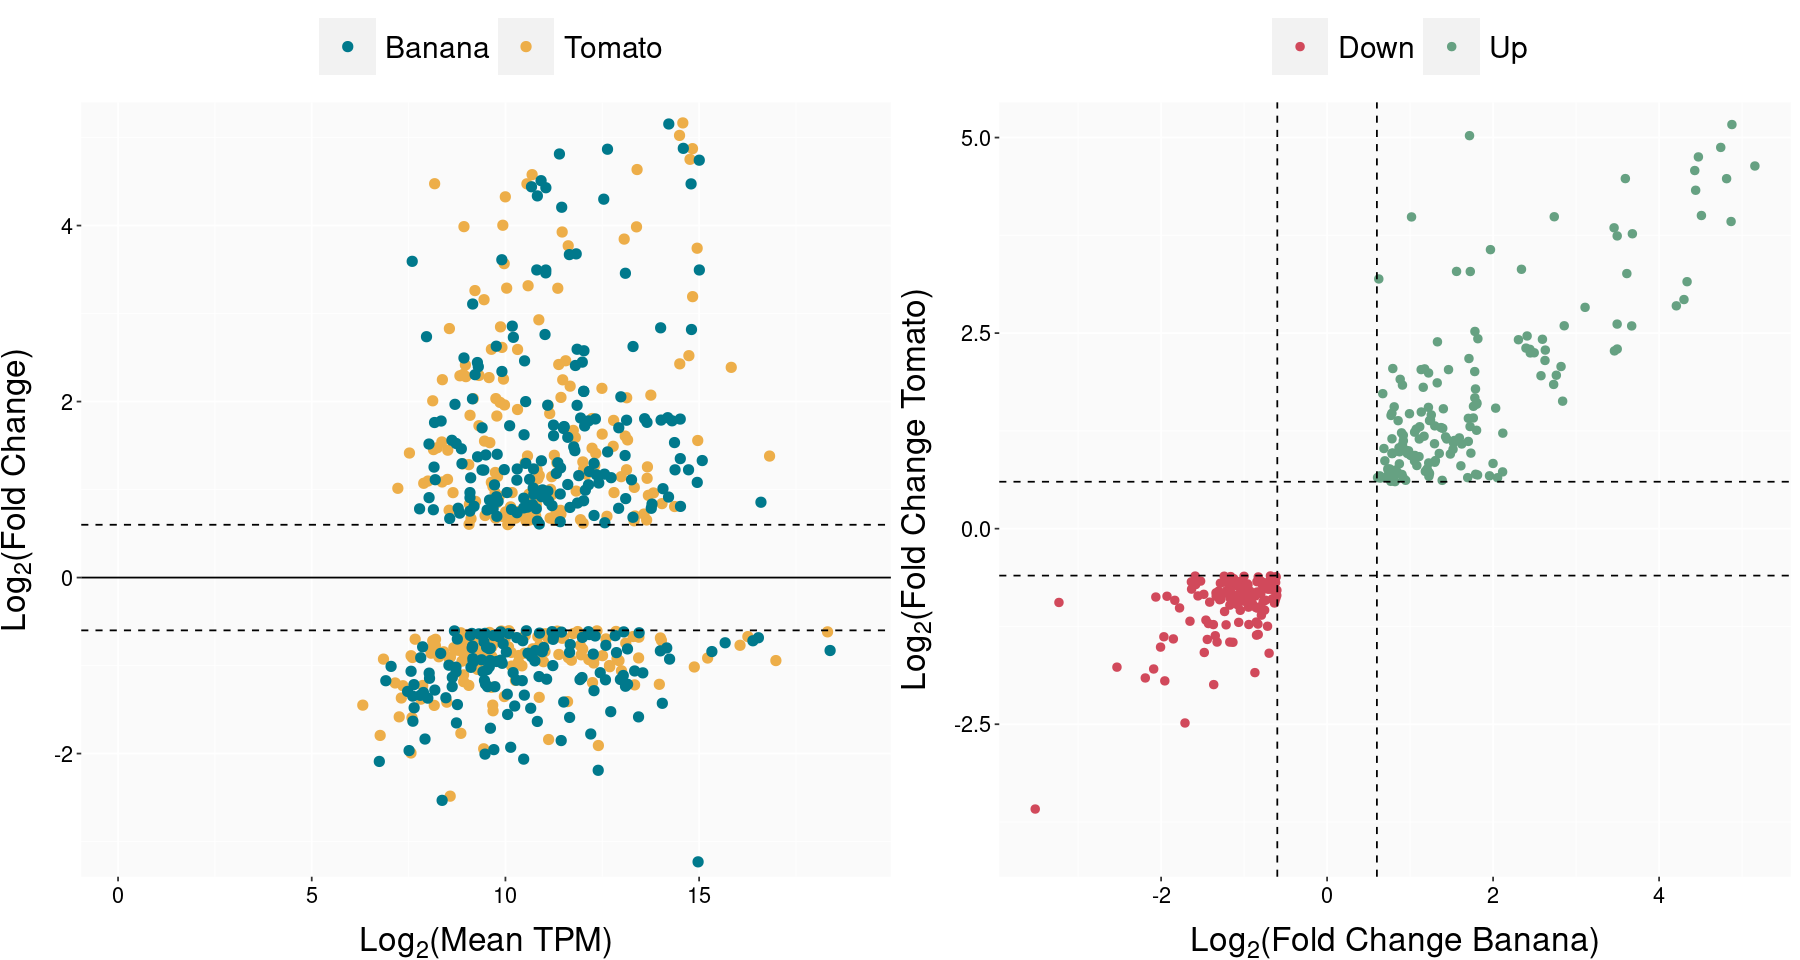

In [6]:
#-------------------------------------------------------------#
#--------------------------Theme ggplot-----------------------#
#-------------------------------------------------------------#
My_Theme = theme(
  axis.title.x = element_text(size=20, vjust=-1),
  axis.text.x = element_text(size = 13, color = "black", vjust=0.5),
  axis.title.y =element_text(size=20, vjust=2, face="bold"),
  axis.text.y = element_text(size = 13,color = "black" ),
  strip.text.x= element_text(size = 22),
  panel.background = element_rect(fill = "grey98"),
  legend.key.size = unit(1.2, "cm"),
  legend.title = element_blank(),
  legend.text = element_text(size = 18), legend.position="top")

#-------------------------------------------------------------#
#--------------------------Maplotting-------------------------#
#-------------------------------------------------------------#
options(repr.plot.width = 8)
options(repr.plot.height = 8)
MAPlot <- ggplot(data=MatPlot, aes(x=TPM, y=Log2FC, color=Origin)) + 
          geom_point(size=2.5)+ My_Theme + 
          xlab(expression(paste(Log[2],"(Mean TPM)")))+
          coord_cartesian(xlim=c(0, 19), ylim=c(-3,5)) +
          ylab(expression(paste(Log[2],"(Fold Change)")))+
          geom_hline(yintercept=0.6, linetype="dashed", color = "black")+
          geom_hline(yintercept=-0.6, linetype="dashed", color = "black") +
          geom_hline(yintercept=0, linetype="solid", color = "black") +
          scale_color_manual(values=c("#00798c", "#edae49"))

#-------------------------------------------------------------#
#--------------------------Scatterplot------------------------#
#-------------------------------------------------------------#
scaterrplot <-ggplot(data=Scatter, aes(x=Log2FC_B, y=Log2FC_T,color=Class))+
          geom_point(size=2)+ My_Theme + geom_hline(yintercept = 0.6,linetype='dashed')+
          geom_vline(xintercept =0.6,linetype='dashed') +
          geom_hline(yintercept = -0.6,linetype='dashed')+
          geom_vline(xintercept =-0.6,linetype='dashed') +
          ylab(expression(paste(Log[2],"(Fold Change Tomato)"))) +
          coord_cartesian(ylim=c(-4,5)) +
          xlab(expression(paste(Log[2],"(Fold Change Banana)")))+
          scale_color_manual(values=c("#d1495b", "#66a182"))

#------------------------------------------------------------#
#----------------------Display together ---------------------#
#------------------------------------------------------------#
options(repr.plot.width = 15) 
options(repr.plot.height = 8)
grid.arrange(MAPlot, scaterrplot, nrow = 1, ncol=2)

### F3. Dot plot

In [40]:
#-------------------------------------------------------------#
#------------------------Data Dot plot------------------------#
#-------------------------------------------------------------#
GO_matrix <- read.table ("Dotplot", sep='\t', header=T)
GO_matrix <- GO_matrix[order(GO_matrix$Counts),]
GO_matrix$Process <- as.character(GO_matrix$Process)
GO_matrix$Process <- factor(GO_matrix$Process, levels=unique(GO_matrix$Process))
head(GO_matrix)

,Process,Gene.ratio,P.value,Genome_Ups,Genome_Downs,Plasmid_Ups,Plasmid_Downs,Counts,Category,Category2
,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>
12,Phenylacetate catabolic process,0.2500000,0.0130,0,0,2,0,2,BP,Shared
22,Peptidase activity,0.2222222,0.0180,0,0,2,0,2,MF,Tomato
38,Extrachromosomal circular DNA,1.0000000,0.0015,0,1,0,1,2,CC,Banana
1,ABC transporter complex,0.0900000,0.0240,3,0,0,0,3,MF,Shared
4,Proteolysis,0.0566000,0.0330,0,3,0,0,3,BP,Shared
33,Metalloendopeptidase activity,0.2307692,0.0043,0,2,0,1,3,MF,Banana


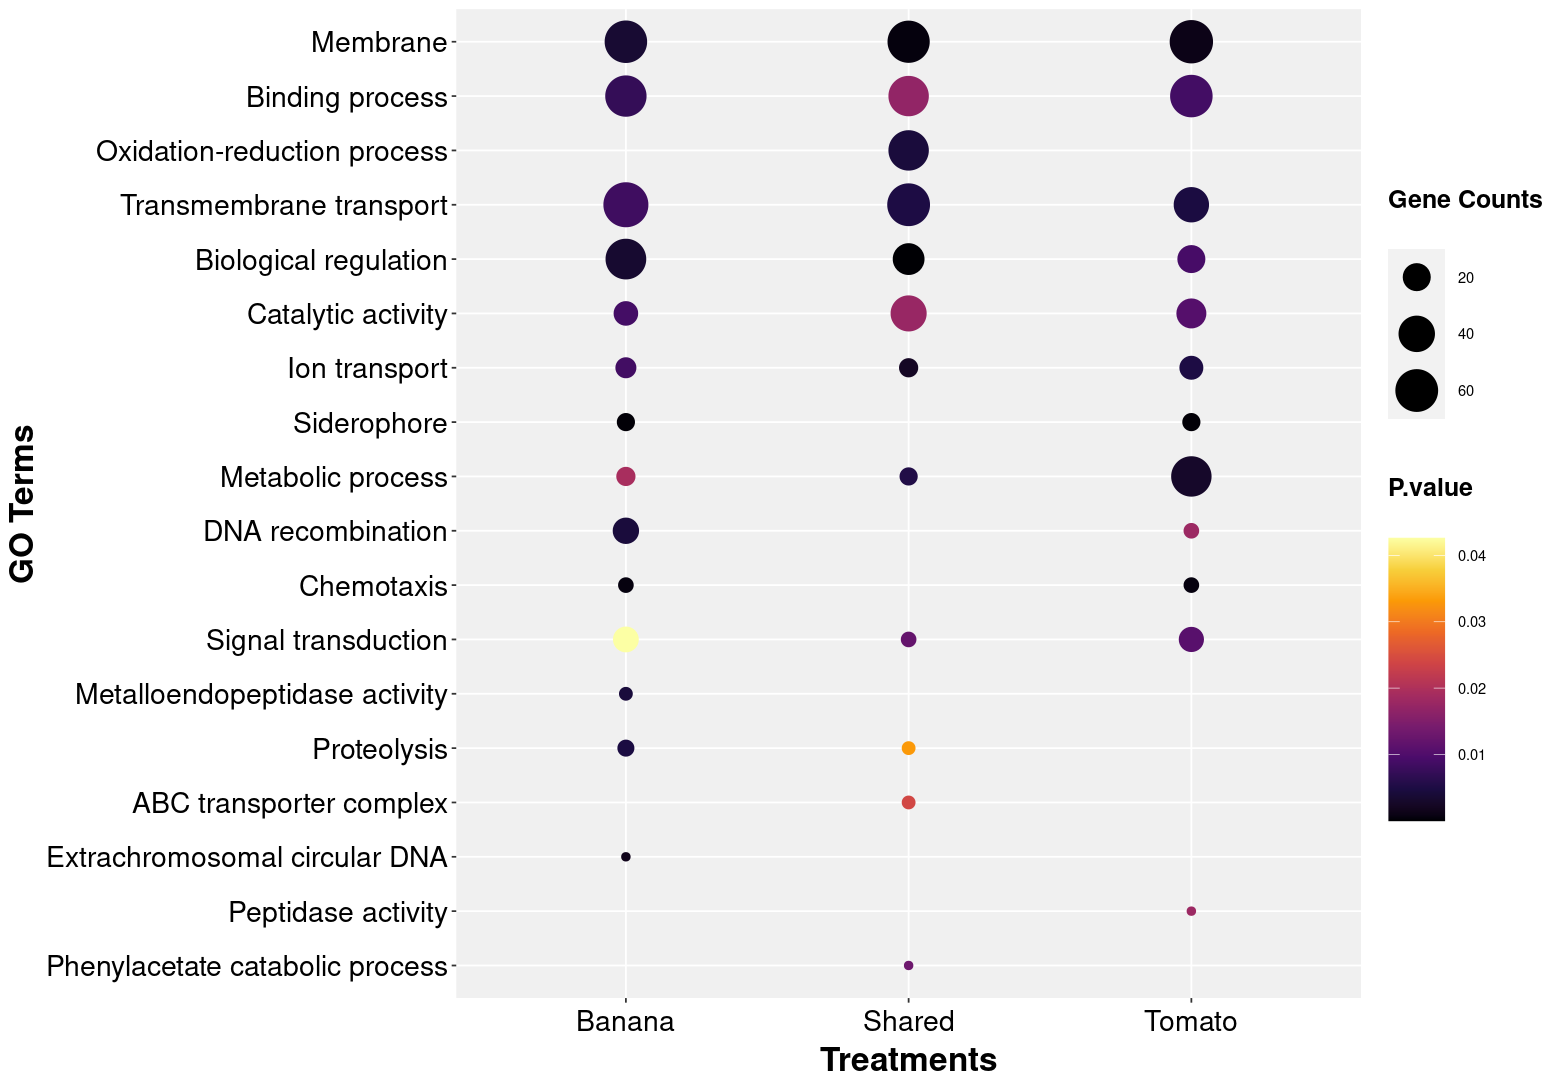

In [41]:
#------------------------------------------------------------#
#-------------------------Theme ggplot-----------------------#
#------------------------------------------------------------#
My_Theme = theme(
  axis.title.x = element_text(size=20, vjust=0.001,face="bold"),
  axis.text.x = element_text(size = 17, color = "black", vjust=0.5),
  axis.title.y =element_text(size=20, vjust=1, face="bold"),
  axis.text.y = element_text(size = 17,color = "black" ),
  strip.text.x= element_text(size = 22),
  panel.background = element_rect(fill = "grey94"),
  legend.spacing.y = unit(0.8, 'cm'),
  legend.key.size = unit(1.2, "cm"),
  legend.title = element_text(size=15, face="bold"))

#------------------------------------------------------------#
#---------------------------Dot plot-------------------------#
#------------------------------------------------------------#
options(repr.plot.width = 13)
options(repr.plot.height = 9)
dots <- ggplot(GO_matrix, aes(x =Category2, y = Process, colour = P.value, size= Counts)) +
        My_Theme + geom_point() + xlab("Treatments") + ylab("GO Terms") +
        guides(size = guide_legend(title = "Gene Counts")) +
        scale_colour_gradientn(colours = inferno(10)) + scale_size(range =  c(2,12))
dots

### F4. Barplot

In [46]:
#------------------------------------------------------------#
#------------------Banana Data Barplot-----------------------#
#------------------------------------------------------------#
GO_banana  <- read.table ("GO_banana.txt", sep='\t', header=T)
GOB_genome <- data.frame(GO_banana$Process,GO_banana$Genome_Ups,GO_banana$Genome_Downs, GO_banana$Category)
colnames(GOB_genome) <- c("Process", "Ups", "Downs", "Category")
GOB_genome <- melt(GOB_genome, id.vars =c( "Process","Category"))
GOB_genome$title <- "Gene Enrichment Genome"
#------------------------Sorted data ------------------------#
GOB_genome <-GOB_genome[order(GOB_genome$Category),] 
GOB_genome$Process<- as.character(GOB_genome$Process)
GOB_genome$Process <- factor(GOB_genome$Process, levels=unique(GOB_genome$Process))

GOB_plasmid <- data.frame(GO_banana$Process,GO_banana$Plasmid_Ups,GO_banana$Plasmid_Downs, GO_banana$Category)
colnames(GOB_plasmid) <- c("Process", "Ups", "Downs", "Category")
GOB_plasmid <- melt(GOB_plasmid, id.vars =c( "Process","Category"))
GOB_plasmid$title <- "Gene Enrichment Plasmid"
#------------------------Sorted data ------------------------#
GOB_plasmid<-GOB_plasmid[order(GOB_plasmid$Category),]
GOB_plasmid$Process<- as.character(GOB_plasmid$Process)
GOB_plasmid$Process <- factor(GOB_plasmid$Process, levels=unique(GOB_plasmid$Process))

#------------------------------------------------------------#
#------------------Tomato Data Barplot-----------------------#
#------------------------------------------------------------#
GO_tomato <- read.table ("GO_Tomato.txt", sep='\t', header=T)
GOT_genome <- data.frame(GO_tomato$Process,GO_tomato$Genome_Ups,GO_tomato$Genome_Downs, GO_tomato$Category)
colnames(GOT_genome) <- c("Process", "Ups", "Downs", "Category")
GOT_genome <- melt(GOT_genome, id.vars = c("Process", "Category"))
GOT_genome$title <- "Gene Enrichment Genome"
#------------------------Sorted data ------------------------#
GOT_genome<-GOT_genome[order(GOT_genome$Category),] 
GOT_genome$Process<- as.character(GOT_genome$Process)
GOT_genome$Process <- factor(GOT_genome$Process, levels=unique(GOT_genome$Process))


GOT_plasmid <- data.frame(GO_tomato$Process,GO_tomato$Plasmid_Ups,GO_tomato$Plasmid_Downs, GO_tomato$Category)
colnames(GOT_plasmid) <- c("Process", "Ups", "Downs", "Category")
GOT_plasmid <- melt(GOT_plasmid, id.vars = c("Process", "Category"))
GOT_plasmid$title <- "Gene Enrichment Plasmid"
#------------------------Sorted data ------------------------#
GOT_plasmid <- GOT_plasmid[order(GOT_plasmid$Category),] 
GOT_plasmid$Process <- as.character(GOT_plasmid$Process)
GOT_plasmid$Process <- factor(GOT_plasmid$Process, levels=unique(GOT_plasmid$Process))

#------------------------------------------------------------#
#------------------Shared Data Barplot-----------------------#
#------------------------------------------------------------#
GO_shared <- read.table ("GO_shared.txt", sep='\t', header=T)
GOS_genome <- data.frame(GO_shared$Process,GO_shared$Genome_Ups,GO_shared$Genome_Downs,GO_shared$Category)
colnames(GOS_genome) <- c("Process", "Ups", "Downs", "Category")
GOS_genome <- melt(GOS_genome, id.vars = c("Process","Category"))
GOS_genome$title <- "Gene Enrichment Genome"
#------------------------Sorted data ------------------------#
GOS_genome <- GOS_genome[order(GOS_genome$Category),] 
GOS_genome$Process <- as.character(GOS_genome$Process)
GOS_genome$Process <- factor(GOS_genome$Process, levels=unique(GOS_genome$Process))

GOS_plasmid <- data.frame(GO_shared$Process,GO_shared$Plasmid_Ups,GO_shared$Plasmid_Downs,GO_shared$Category)
colnames(GOS_plasmid) <- c("Process", "Ups", "Downs","Category")
GOS_plasmid <- melt(GOS_plasmid, id.vars = c("Process","Category"))
GOS_plasmid$title <- "Gene Enrichment Plasmid"
#------------------------Sorted data ------------------------#
GOS_plasmid <-GOS_plasmid[order(GOS_plasmid$Category),] 
GOS_plasmid$Process <- as.character(GOS_plasmid$Process)
GOS_plasmid$Process <- factor(GOS_plasmid$Process, levels=unique(GOS_plasmid$Process))

head(GO_banana) # http://gseapro.molgenrug.nl/

,Process,Gene.ratio,P.Value,Genome_Ups,Genome_Downs,Plasmid_Ups,Plasmid_Downs,Counts,Category
,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<fct>
1,Binding process,0.07275132,0.00720,6,27,4,18,55,MF
2,Ion transport,0.28125000,0.00855,0,5,0,4,9,MF
3,Metabolic process,0.13461539,0.01930,0,3,2,2,7,BP
4,Transmembrane transport,0.14561028,0.00826,13,21,12,22,68,MF
5,Catalytic activity,0.03814714,0.00880,6,2,4,2,14,MF
6,Membrane,0.08625731,0.00351,20,12,12,15,59,CC


In [37]:
#------------------------------------------------------------#
#----------------------Theme genome ggplot-------------------#
#------------------------------------------------------------#
My_Theme_genome = theme(
  axis.title.x = element_text(size=20, vjust=0.001,face="bold"),
  axis.text.x = element_text(size = 17, color = "black", vjust=0.5),
  axis.title.y =element_text(size=20, vjust=1, face="bold"),
  axis.text.y = element_text(size = 17,color = "black" ),
  strip.text.x= element_text(size = 22),
  legend.position = "none",
  panel.background = element_rect(fill = "grey95"))

#------------------------------------------------------------#
#---------------------Theme plasmid ggplot-------------------#
#------------------------------------------------------------#
My_Theme_plasmid = theme(
  axis.title.x = element_text(size=20, vjust=0.001,face="bold"),
  axis.text.x = element_text(size = 17, color = "black", vjust=0.5),
  strip.text.x= element_text(size = 22),
  panel.background = element_rect(fill = "grey95"),
  axis.title.y=element_blank(),
  axis.text.y=element_blank(),
  axis.ticks.y=element_blank(),
  legend.spacing.y = unit(1.0, 'cm'),
  legend.key.size = unit(1.2, "cm"))

In [38]:
#------------------------------------------------------------#
#----------------------Barplot Banana------------------------#
#------------------------------------------------------------#
options(repr.plot.width = 10) 
options(repr.plot.height = 8) 
Bbarp_genome <- ggplot(GOB_genome, aes(x=value, y=Process, fill=variable, linetype = Category )) +
        geom_bar(stat="identity", color="black", alpha=1, width = 0.5, size=1) + My_Theme_genome +
        xlab("Genes counts")+ ylab("Banana GO Terms") +   facet_grid(. ~ title) +
        scale_fill_manual(values=c("#00C08D","#F8766D"))+
        scale_linetype_manual(values=c("solid","dotted","dotdash"))

options(repr.plot.width = 15) 
options(repr.plot.height = 8)
Bbarp_plasmid <- ggplot(GOB_plasmid, aes(x=value, y=Process, fill=variable, linetype= Category)) +
        geom_bar(stat="identity", color="black", alpha=1, width = 0.5, size=0.8) + My_Theme_plasmid +
        xlab("Genes counts")+ ylab("Banana GO Terms") +   facet_grid(. ~ title) + 
        theme (legend.title = element_blank(), legend.text = element_text(size = 18)) +
        scale_fill_manual(values=c("#00C08D","#F8766D"))+
        scale_linetype_manual(values=c("solid","dotted","dotdash"))+
        guides(linetype = guide_legend(override.aes= list(fill = "white")))

#------------------------------------------------------------#
#----------------------Barplot Tomato------------------------#
#------------------------------------------------------------#
options(repr.plot.width = 10)
options(repr.plot.height = 8)
Tbarp_genome <- ggplot(GOT_genome, aes(x=value, y=Process, fill=variable, linetype = Category )) +
        geom_bar(stat="identity", color="black", alpha=1, width = 0.5, size=0.8) + My_Theme_genome +
        xlab("Genes counts")+ ylab("Tomato GO Terms") +   facet_grid(. ~ title) +
        scale_fill_manual(values=c("#00C08D","#F8766D"))+
        scale_linetype_manual(values=c("solid","dotted","dotdash"))

options(repr.plot.width = 15) 
options(repr.plot.height = 8) 
Tbarp_plasmid <- ggplot(GOT_plasmid, aes(x=value, y=Process, fill=variable, linetype= Category)) +
        geom_bar(stat="identity", color="black", alpha=1, width = 0.5, size=0.9) + My_Theme_plasmid +
        xlab("Genes counts")+ ylab("GO Terms") +   facet_grid(. ~ title) + 
        theme (legend.title = element_blank(), legend.text = element_text(size = 18)) +
        scale_fill_manual(values=c("#00C08D","#F8766D")) +
        scale_linetype_manual(values=c("solid","dotted","dotdash")) + 
        guides(linetype = guide_legend(override.aes= list(fill = "white")))

#------------------------------------------------------------#
#----------------------Barplot Shared------------------------#
#------------------------------------------------------------#

Sbarp_genome <- ggplot(GOS_genome, aes(x=value, y=Process, fill=variable, linetype = Category )) +
        geom_bar(stat="identity", color="black", alpha=1, width = 0.5, size=1) + My_Theme_genome +
        xlab("Genes counts")+ ylab("Shared GO Terms") +   facet_grid(. ~ title) +
        scale_fill_manual(values=c("#00C08D","#F8766D")) +
        scale_linetype_manual(values=c("solid","dotted","dotdash"))

Sbarp_plasmid <- ggplot(GOS_plasmid, aes(x=value, y=Process, fill=variable, linetype= Category)) +
        geom_bar(stat="identity", color="black", alpha=1, width = 0.5, size=0.9) + My_Theme_plasmid +
        xlab("Genes counts")+ ylab("GO Terms") +   facet_grid(. ~ title) + 
        theme (legend.title = element_blank(), legend.text = element_text(size = 18)) +
        scale_fill_manual(values=c("#00C08D","#F8766D"))+
        scale_linetype_manual(values=c("solid","dotted","dotdash"))+
        guides(linetype = guide_legend(override.aes= list(fill = "white")))

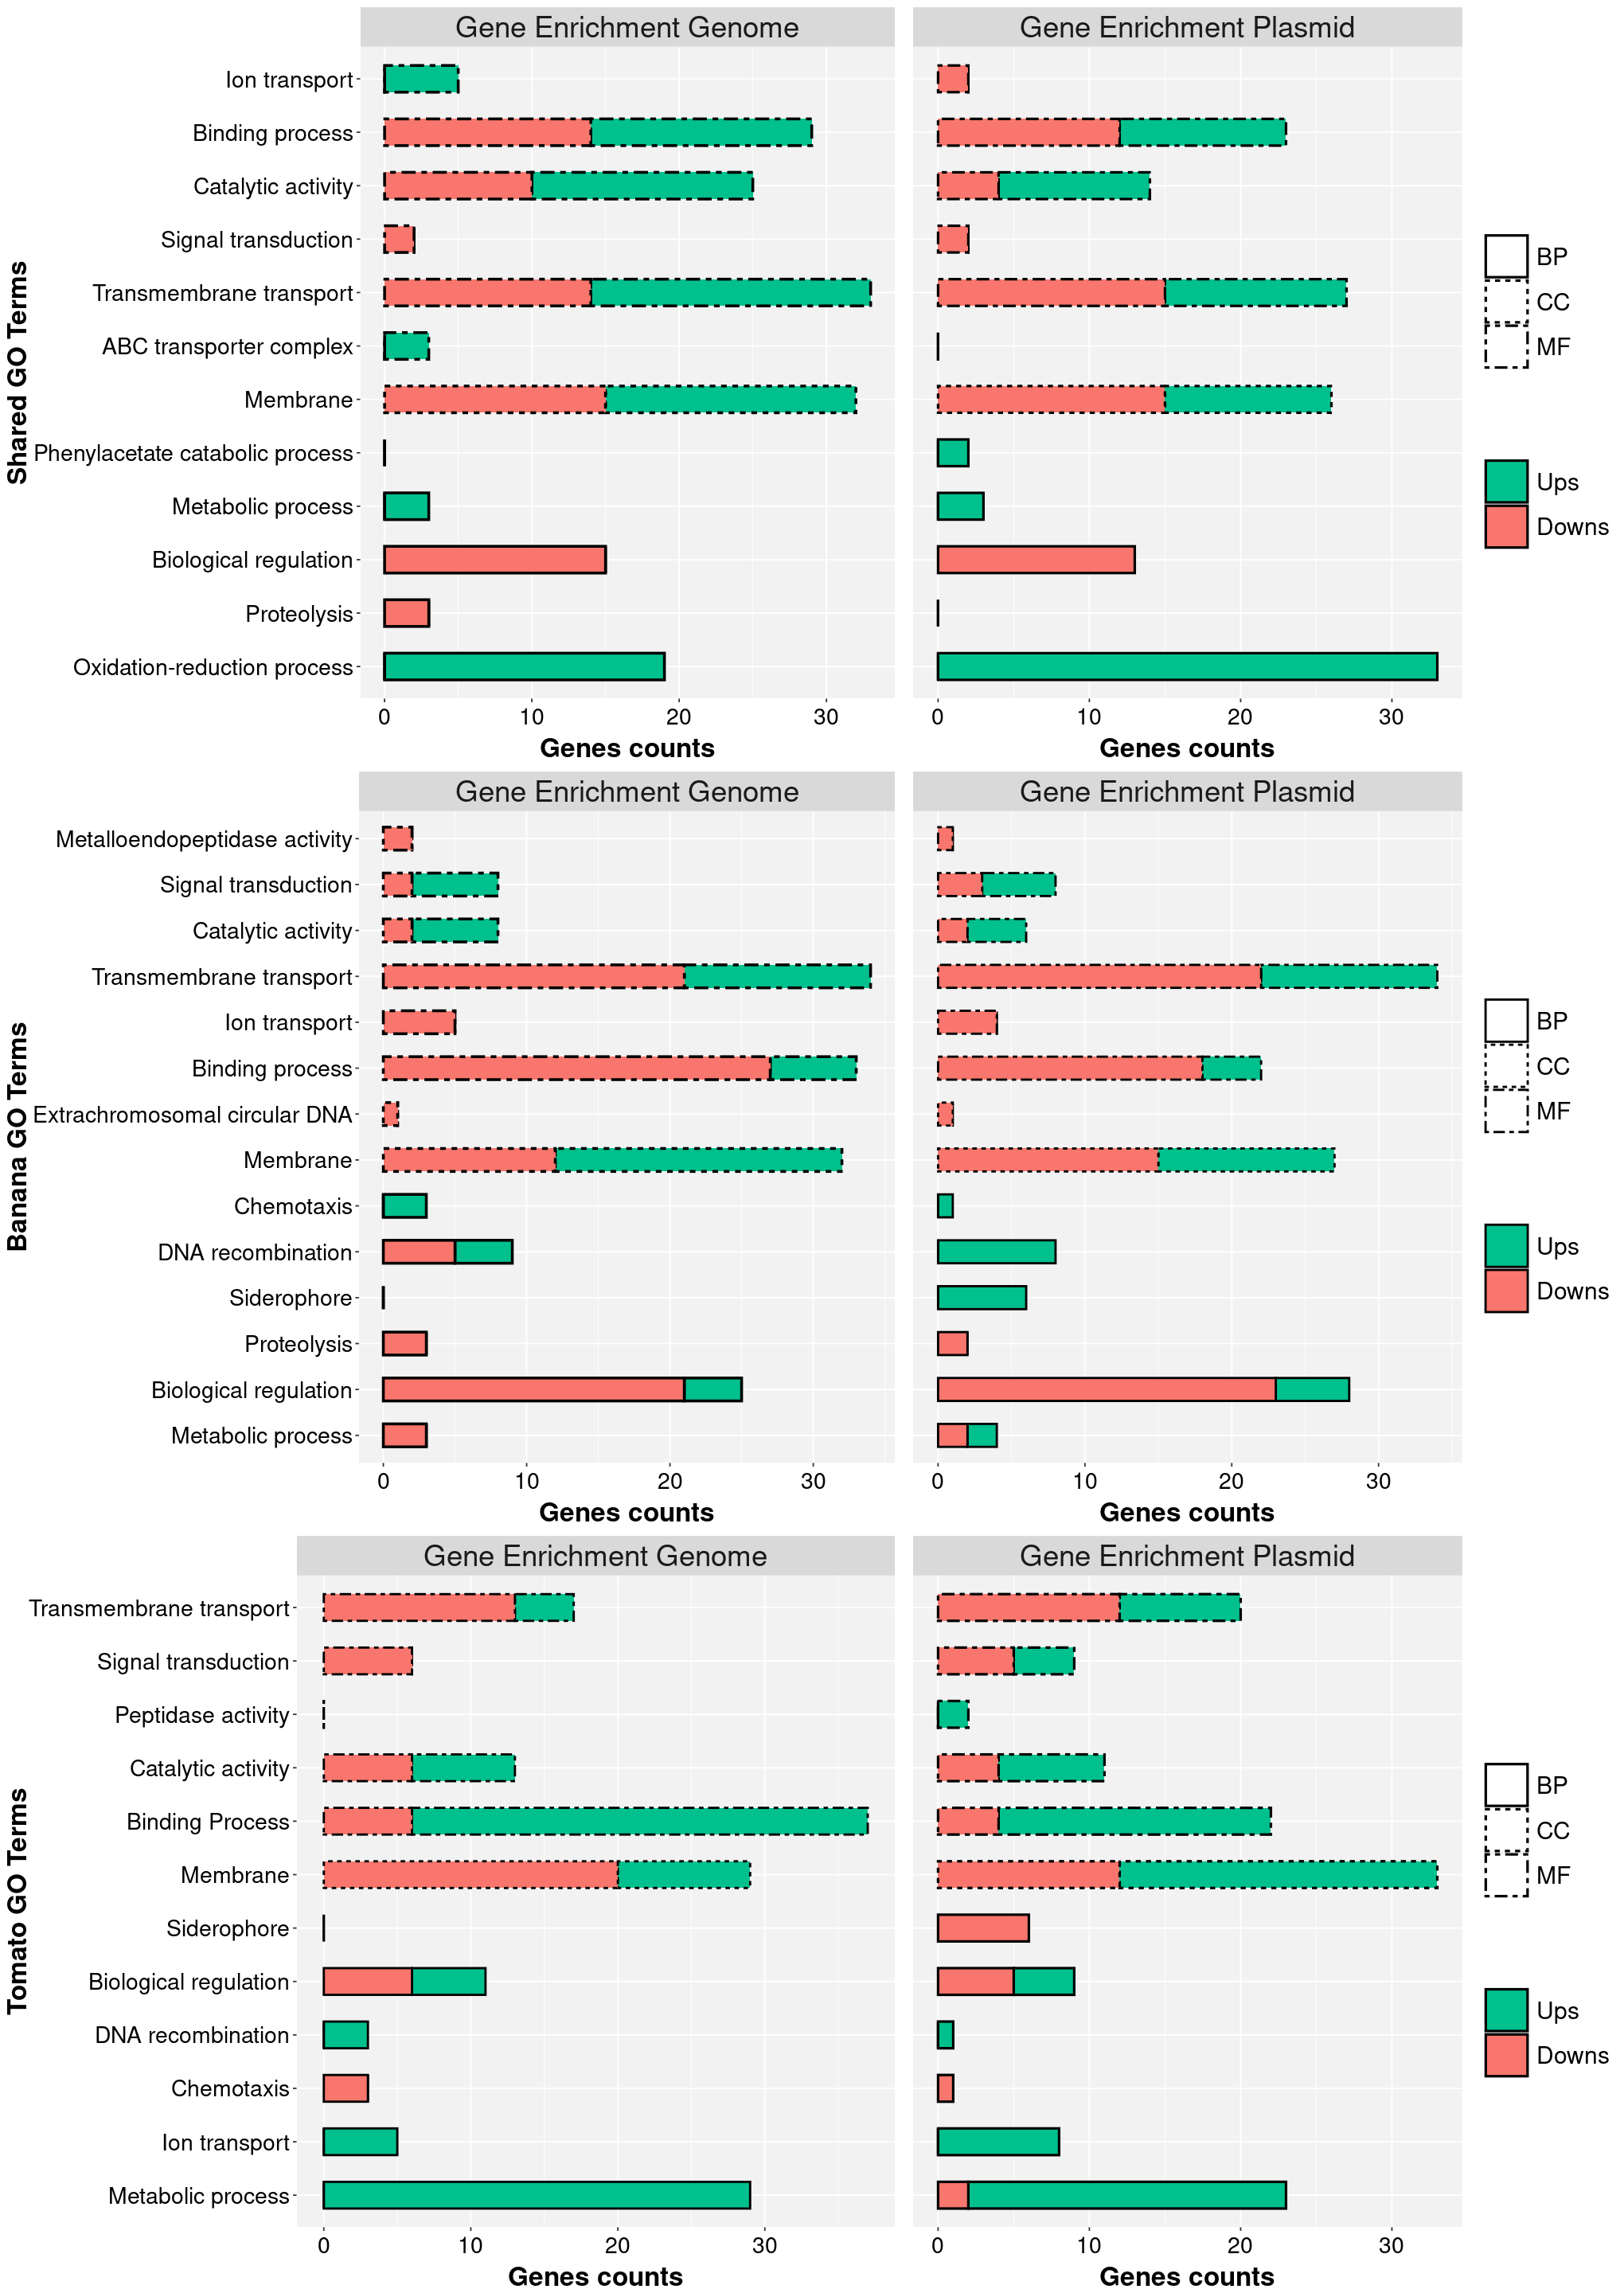

In [39]:
#------------------------------------------------------------#
#---------------Display together Barplot---------------------#
#------------------------------------------------------------#
options( warn = -1 )
options(repr.plot.width = 17) 
options(repr.plot.height = 24) 
suppressWarnings(BarplotDEGS_Plot <- grid.arrange(Sbarp_genome,Sbarp_plasmid,Bbarp_genome, 
                                     Bbarp_plasmid, Tbarp_genome,Tbarp_plasmid, nrow = 3, ncol=2, widths = c(10, 8)))